# Creating a pipeline for determining coding effects based on sensor editing

- Take the edited protospacer and place it in the transcript to compute protein coding effects
- Edge cases:
    - When protospacer is on the boundary of an exon
    - Need to throw out reads that are too far away in sequence distance because these are likely artifacts (e.g. more than 6 nt away by hamming distance)

In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import scipy.stats
import os
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects
import warnings
warnings.filterwarnings('ignore')
plt.rc('font', family='Helvetica')


from pegg import prime 
import Bio.Seq
import gffutils


# 1. Pre-processing

# 1a. Generating information about proteins being mutagenized

In [11]:
#load genome and genome annotations
#here I'm using GrCH37 and the associated annotation file
#this depends on the genome you used to generate your library

#filepath = '/Users/samgould/Desktop/FSR Lab/reference files/GRCh38/ncbi-genomes-2022-02-23/GCF_000001405.26_GRCh38_genomic.fna.gz'
filepath = '/Users/samgould/Desktop/FSR Lab/reference files/grch37_unzipped/GCF_000001405.25_GRCh37.p13_genomic.fna.gz'
chrom_dict, i = prime.genome_loader(filepath)

#db = gffutils.FeatureDB('/Users/samgould/Desktop/FSR Lab/reference files/gencode_v44_GRCh38.db', keep_order=True)
db = gffutils.FeatureDB('/Users/samgould/Desktop/FSR Lab/reference files/gencode_v19.db', keep_order=True)

In [12]:
def tx_processor(tx):
    cds = list(db.children(tx, order_by='+end', featuretype=['CDS']))
    start_end_cds = [[i.start, i.end] for i in cds]
    strand = db[tx].strand
    chrom = db[tx].chrom
    #print(chrom[3:])
    #print(strand)
    #print(db[tx].attributes)

    #including 20 nt buffer on either side of exon for generating PAM sequences
    start_end_cds_20 = []
    buffer = 20
    for k in start_end_cds:
        h = []
        for idx, j in enumerate(k):
            if idx==0:
                h.append(j-buffer)
            if idx==1:
                h.append(j+buffer)
        start_end_cds_20.append(h)

    return start_end_cds_20, start_end_cds, chrom, strand

## Load dataframe and check for correct format

In [159]:
df = pd.read_csv('library_files/idrms_protospacer_coordinates_and_transcript_IDs_corrected.csv')
for i, val in df.iterrows():
    p_full = val['Protospacer_Matched']
    p_g19 = val['Protospacer']

    assert p_g19[1:]==p_full[1:]

In [160]:
t_small = df[['Protospacer_Matched', 'Chromosome', 'Protospacer_Start', 'Protospacer_End', 'PAM_Strand']]

t_small = t_small.rename(columns = {'Protospacer_Matched':'protospacer', 'Chromosome':'chrom', 'PAM_Strand':'strand', 'Protospacer_Start':'proto_start', 'Protospacer_End':'proto_end'})

for i, val in t_small.iterrows():
    s = int(val['proto_start'])
    e = int(val['proto_end'])
    if val['chrom'] in ['X', 'Y']:
        c = val['chrom']
    else:
        c = int(val['chrom'])
    strand = val['strand']

    protospacer = val['protospacer']

    if strand =='+':
        proto = chrom_dict[c][s-1:e].upper()
        assert proto == protospacer, print(proto, protospacer)

    elif strand == '-':
        #in this case, proto_start is LARGER than proto_end
        proto = Bio.Seq.Seq(chrom_dict[c][e-1:s].upper()).reverse_complement()
        assert proto==protospacer, print(proto, protospacer)

In [161]:
#and generate the gene information table
df_genes = df.copy()
df_genes = df_genes.drop_duplicates(subset='Transcript_ID')[['Hugo_Symbol', 'Transcript_ID']].rename(columns = {'Hugo_Symbol':'Gene', 'Transcript_ID':'Transcript ID'}).reset_index(drop=True)

#also drop duplicate genes
#only allow one gene/transcript ID combo
#can be modified later on in theory
df_genes = df_genes.drop_duplicates(subset='Gene').reset_index(drop=True)
df_genes

,Gene,Transcript ID
0,ABCB11,ENST00000263817.6
1,ABL1,ENST00000318560.5
2,ABL2,ENST00000502732.1
3,ACVR1,ENST00000263640.3
4,ADAMTS20,ENST00000389420.3
...,...,...
591,ZNF217,ENST00000302342.3
592,ZNF521,ENST00000361524.3
593,ZNF703,ENST00000331569.4
594,ZNRF3,ENST00000544604.2


In [162]:
def gene_preprocessor(df_genes):

    wt_tx = []
    protein_seq = []
    for gene in df_genes['Gene']:
        tx = df_genes.loc[df_genes['Gene']==gene, 'Transcript ID'].values[0]


        #--------check that it's the correct transcript and get the WT transcript sequence-------
        start_end_cds_20, start_end_cds, chrom, strand = tx_processor(tx)

        if chrom in ['chrX','chrY']:
            chr9 = chrom_dict[chrom[3:]]
        else:
            chr9 = chrom_dict[int(chrom[3:])]

        tx_idx = []
        transcript = ''
        for i in start_end_cds:
            s = i[0]-1
            e = i[1]
            transcript+=chr9[s:e]
            for k in range(i[0], i[1]+1):
                tx_idx.append(k)

        if strand == '+':
            WT_transcript_full = str(transcript).upper()
        elif strand =='-':
            WT_transcript_full = str(transcript.reverse_complement()).upper()


        #and generate the protein sequence
        protein = str(Bio.Seq.Seq(WT_transcript_full).transcribe().translate())
        protein_seq.append(protein)

        assert '*' not in protein, print(f'{tx} error; STOP codon detected in transcript')

        wt_tx.append(WT_transcript_full)

    df_genes['Protein'] = protein_seq
    df_genes['WT_tx_full'] = wt_tx
    df_genes['Protein length'] = [len(i) for i in protein_seq]
    df_genes['tx length'] = [len(i) for i in wt_tx]

    return df_genes

In [164]:
df_genes = gene_preprocessor(df_genes)

#and saving it
df_genes.to_csv('library_files/IDR_library_gene_info.csv', index=False)

# And then processing library

- Determines the location of the protospacer within the cDNA sequence
- Make sure to remove the intron/non-coding targeting gRNAs (will result in error)

In [128]:
#for plus strand protospacers
def simulate_mutations_plus(input_df, start_end_cds, strand, tx_idx, WT_transcript_full):

    #chr9 = chrom_dict[int(chrom[3:])]

    potential_splice_holder = []
    contained_start_holder = []
    contained_end_holder = []
    s_prot = []
    e_prot = []
    s_cdna = []
    e_cdna = []

    if strand =='+':
        idx_dict = dict(zip(tx_idx, list(range(len(tx_idx)))))
    elif strand =='-':
        idx_dict = dict(zip(tx_idx[::-1], list(range(len(tx_idx)))))

    #wt_seq = str(Bio.Seq.Seq(WT_transcript_full).transcribe().translate())

    for i, val in input_df.iterrows():
        ideal_start = int(val['proto_start'])
        ideal_end = int(val['proto_end'])

        mut_transcript = ''
        wt_transcript = ''

        potential_splice = False
        error_detected = False

        for i in start_end_cds:
            s = i[0]
            e = i[1]
   
            contained_start = False
            contained_end = False

            if ((ideal_end <= e) and (ideal_end>=s) and (ideal_start <= e) and (ideal_start>=s)):

                contained_start = True
                contained_end = True
                s_prot.append(0)
                e_prot.append(20)
                if strand =='+':
                    s_cdna.append(idx_dict[ideal_start])
                    e_cdna.append(idx_dict[ideal_end]+1)
                elif strand =='-':
                    s_cdna.append(idx_dict[ideal_end])
                    e_cdna.append(idx_dict[ideal_start]+1)

                potential_splice_holder.append(potential_splice)
                contained_start_holder.append(contained_start)
                contained_end_holder.append(contained_end)

            else:
                if ((ideal_start <= e) and (ideal_start>=s)):
                    contained_start = True
                    potential_splice=True
                    s_prot.append(0)
                    e_prot.append(20-(ideal_end-e))
                    
                    if strand == '+':
                        s_cdna.append(idx_dict[ideal_start])
                        e_cdna.append(idx_dict[e]+1)

                    elif strand == '-':
                        s_cdna.append(idx_dict[e])
                        e_cdna.append(idx_dict[ideal_start]+1)


                    potential_splice_holder.append(potential_splice)
                    contained_start_holder.append(contained_start)
                    contained_end_holder.append(contained_end)

                elif ((ideal_end <= e) and (ideal_end>=s)):
                    contained_end=True
                    potential_splice=True
                    e_prot.append(20)
                    s_prot.append(s-ideal_start)

                    if strand == '+':
                        s_cdna.append(idx_dict[s])
                        e_cdna.append(idx_dict[ideal_end]+1)
                    elif strand =='-':
                        s_cdna.append(idx_dict[ideal_end])
                        e_cdna.append(idx_dict[s]+1)


                    potential_splice_holder.append(potential_splice)
                    contained_start_holder.append(contained_start)
                    contained_end_holder.append(contained_end)

    

    try:
        input_df['potential_splice'] = potential_splice_holder
        input_df['contained_start'] = contained_start_holder
        input_df['contained_end'] = contained_end_holder
        input_df['prot_start'] = [int(i) for i in s_prot]
        input_df['prot_end'] = [int(i) for i in e_prot]
        input_df['cdna_start'] = [int(i) for i in s_cdna]
        input_df['cdna_end'] = [int(i) for i in e_cdna]
        input_df['error_detected'] = False
    except:
        input_df['error_detected'] = True


    if strand =='+':
        input_df['orientation'] = 'for'
    
    elif strand =='-':
        input_df['orientation'] = 'rev'

    return input_df
            

In [129]:
#for minus strand protospacers
def simulate_mutations_minus(input_df, start_end_cds, strand, tx_idx, WT_transcript_full):

    #chr9 = chrom_dict[int(chrom[3:])]

    potential_splice_holder = []
    contained_start_holder = []
    contained_end_holder = []
    s_prot = []
    e_prot = []
    s_cdna = []
    e_cdna = []

    if strand =='+':
        idx_dict = dict(zip(tx_idx, list(range(len(tx_idx)))))
    elif strand =='-':
        idx_dict = dict(zip(tx_idx[::-1], list(range(len(tx_idx)))))

    #wt_seq = str(Bio.Seq.Seq(WT_transcript_full).transcribe().translate())

    for i, val in input_df.iterrows():
        ideal_start = int(val['proto_end'])
        ideal_end = int(val['proto_start'])

        mut_transcript = ''
        wt_transcript = ''

        potential_splice = False
        error_detected = False

        for i in start_end_cds:
            s = i[0]
            e = i[1]
   
            contained_start = False
            contained_end = False

            if ((ideal_end <= e) and (ideal_end>=s) and (ideal_start <= e) and (ideal_start>=s)):

                contained_start = True
                contained_end = True
                s_prot.append(0)
                e_prot.append(20)
                if strand =='+':
                    s_cdna.append(idx_dict[ideal_start])
                    e_cdna.append(idx_dict[ideal_end]+1)
                elif strand =='-':
                    s_cdna.append(idx_dict[ideal_end])
                    e_cdna.append(idx_dict[ideal_start]+1)

                potential_splice_holder.append(potential_splice)
                contained_start_holder.append(contained_start)
                contained_end_holder.append(contained_end)

            else:
                if ((ideal_start <= e) and (ideal_start>=s)):
                    contained_start = True
                    potential_splice=True
                    s_prot.append(0)
                    e_prot.append(20-(ideal_end-e))
                    
                    if strand == '+':
                        s_cdna.append(idx_dict[ideal_start])
                        e_cdna.append(idx_dict[e]+1)

                    elif strand == '-':
                        s_cdna.append(idx_dict[e])
                        e_cdna.append(idx_dict[ideal_start]+1)


                    potential_splice_holder.append(potential_splice)
                    contained_start_holder.append(contained_start)
                    contained_end_holder.append(contained_end)
                    

                elif ((ideal_end <= e) and (ideal_end>=s)):
                    contained_end=True
                    potential_splice=True
                    e_prot.append(20)
                    s_prot.append(s-ideal_start)

                    if strand == '+':
                        s_cdna.append(idx_dict[s])
                        e_cdna.append(idx_dict[ideal_end]+1)
                    elif strand =='-':
                        s_cdna.append(idx_dict[ideal_end])
                        e_cdna.append(idx_dict[s]+1)


                    potential_splice_holder.append(potential_splice)
                    contained_start_holder.append(contained_start)
                    contained_end_holder.append(contained_end)
                    


    #if error_detected==True:
    
    #else:
    try:
        input_df['potential_splice'] = potential_splice_holder
        input_df['contained_start'] = contained_start_holder
        input_df['contained_end'] = contained_end_holder
        input_df['prot_start'] = [int(20-i) for i in e_prot] #flipping these for consistency of indexing
        input_df['prot_end'] = [int(20-i) for i in s_prot]
        input_df['cdna_start'] = [int(i) for i in s_cdna]
        input_df['cdna_end'] = [int(i) for i in e_cdna]
        input_df['error_detected'] = False
    except:
        input_df['error_detected'] = True


    #flipped here
    if strand =='+':
        input_df['orientation'] = 'rev'
    
    elif strand =='-':
        input_df['orientation'] = 'for'

    return input_df

In [153]:
def library_processor(df_genes, targ):
    """ 
    df_genes = gene info dataframe (generated from code above)
    targ = library file
        Required columns:
        - protospacer: 20 nt protospacer (not G+19 protospacer)
        - proto_start: start of protospacer 
        - proto_end: end of protospacer (if on - strand, proto_end < proto_start)
        - strand: PAM sequence/protospacer strand
        - Gene: match up with df_genes file
        
    """

    df_holder = []

    #combining everything and running it all:
    for gene in df_genes['Gene']:
        input_df_minus = targ[(targ['Gene']==gene) & (targ['strand']=='-')].reset_index(drop=True)
        input_df_plus = targ[(targ['Gene']==gene) & (targ['strand']=='+')].reset_index(drop=True)

        tx = df_genes.loc[df_genes['Gene']==gene, 'Transcript ID'].values[0]
        protein = df_genes.loc[df_genes['Gene']==gene, 'Protein'].values[0]
        wt_tx = df_genes.loc[df_genes['Gene']==gene, 'WT_tx_full'].values[0]

        #--------check that it's the correct transcript and get the WT transcript sequence-------
        start_end_cds_20, start_end_cds, chrom, strand = tx_processor(tx)
        
        if chrom in ['chrX','chrY']:
                chr9 = chrom_dict[chrom[3:]]
        else:
            chr9 = chrom_dict[int(chrom[3:])]

        tx_idx = []
        transcript = ''
        for i in start_end_cds:
            s = i[0]-1
            e = i[1]
            transcript+=chr9[s:e]
            for k in range(i[0], i[1]+1):
                tx_idx.append(k)

        if strand == '+':
            WT_transcript_full = str(transcript).upper()
        elif strand =='-':
            WT_transcript_full = str(transcript.reverse_complement()).upper()

        assert str(Bio.Seq.Seq(WT_transcript_full).transcribe().translate()) == protein
        assert wt_tx == WT_transcript_full

        id = simulate_mutations_minus(input_df_minus, start_end_cds, strand, tx_idx, WT_transcript_full)
        id2 = simulate_mutations_plus(input_df_plus, start_end_cds, strand, tx_idx, WT_transcript_full)

        combined = pd.concat((id2, id))

        #print(f'{gene}: {list(np.unique(combined["error_detected"]))}')
        if True not in list(np.unique(combined['error_detected'])):
            #make sure its an int
            combined['prot_start'] = combined['prot_start'].apply(lambda x: int(x))
            combined['prot_end'] = combined['prot_end'].apply(lambda x: int(x))
            combined['cdna_start'] = combined['cdna_start'].apply(lambda x: int(x))
            combined['cdna_end'] = combined['cdna_end'].apply(lambda x: int(x))

            for i, val in combined.iterrows():

                p = val['protospacer']
                p_s = val['prot_start']
                p_e = val['prot_end']
                c_s = val['cdna_start']
                c_e = val['cdna_end']

                orientation = val['orientation']

                if orientation == 'rev':
                    assert str(Bio.Seq.Seq(p[p_s:p_e]).reverse_complement()) == WT_transcript_full[c_s:c_e]
                elif orientation =='for':
                    assert p[p_s:p_e]==WT_transcript_full[c_s:c_e]

        elif True in list(np.unique(combined['error_detected'])):
            #print('adsfad')
            print(f'Error in {gene} gRNAs...EXCLUDE FROM FUTURE ANALYSIS')

        df_holder.append(combined)

    master_df = pd.concat(df_holder).reset_index(drop=True)  

    return master_df

In [165]:
df_genes = pd.read_csv('library_files/IDR_library_gene_info.csv')

#reading in library file and putting in correct format
df = pd.read_csv('library_files/idrms_protospacer_coordinates_and_transcript_IDs_corrected.csv')
df = df.rename(columns = {'Protospacer':'proto_G+19', 'Protospacer_Matched':'protospacer', 'Chromosome':'chrom', 'PAM_Strand':'strand', 'Protospacer_Start':'proto_start', 'Protospacer_End':'proto_end', 'Hugo_Symbol':'Gene'})
df = df.drop(columns  = ['Unnamed: 0', 'Unnamed: 0.1'])
targ = df


master_df = library_processor(df_genes, targ)

Error in MECOM gRNAs...EXCLUDE FROM FUTURE ANALYSIS
Error in NRG1 gRNAs...EXCLUDE FROM FUTURE ANALYSIS


In [171]:
master_df_no_errors = master_df[master_df['error_detected']==False].reset_index(drop=True)
#cast these values as ints
master_df_no_errors['prot_start'] = master_df_no_errors['prot_start'].apply(lambda x: int(x))
master_df_no_errors['prot_end'] = master_df_no_errors['prot_end'].apply(lambda x: int(x))
master_df_no_errors['cdna_start'] = master_df_no_errors['cdna_start'].apply(lambda x: int(x))
master_df_no_errors['cdna_end'] = master_df_no_errors['cdna_end'].apply(lambda x: int(x))

master_df_no_errors.to_csv('library_files/IDR_library_master_df_no_error.csv', index=False)


In [176]:
master_df_no_errors

,Gene,chrom,Start_Position,Variant_Index,Variant_Classification,Tumor_Sample_Barcode,HGVSc,HGVSp,HGVSp_Short,Transcript_ID,...,proto_end,potential_splice,contained_start,contained_end,prot_start,prot_end,cdna_start,cdna_end,error_detected,orientation
0,ABCB11,2,169870844.0,1.0,Missense_Mutation,GENIE-DFCI-049915-173015,ENST00000263817.6:c.119G>A,p.Gly40Asp,p.G40D,ENST00000263817.6,...,169870858.0,False,True,True,0,20,104,124,False,rev
1,ABCB11,2,169874613.0,1.0,Missense_Mutation,GENIE-DFCI-094691-526412,ENST00000263817.6:c.23G>A,p.Arg8Gln,p.R8Q,ENST00000263817.6,...,169874625.0,False,True,True,0,20,10,30,False,rev
2,ABCB11,2,169874613.0,2.0,Missense_Mutation,GENIE-DFCI-094691-526412,ENST00000263817.6:c.23G>A,p.Arg8Gln,p.R8Q,ENST00000263817.6,...,169874629.0,False,True,True,0,20,6,26,False,rev
3,ABCB11,2,169820802.0,1.0,Missense_Mutation,GENIE-DFCI-202451-2904485,ENST00000263817.6:c.2092C>T,p.Arg698Cys,p.R698C,ENST00000263817.6,...,169820790.0,False,True,True,0,20,2084,2104,False,for
4,ABL1,9,133759923.0,3.0,Missense_Mutation,GENIE-DFCI-132233-1414148,ENST00000318560.5:c.2246C>T,p.Ser749Leu,p.S749L,ENST00000318560.5,...,133759937.0,False,True,True,0,20,2240,2260,False,for
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12752,ZRSR2,X,15841235.0,2.0,Missense_Mutation,GENIE-PROV-1652e038c8-ae21dcd08b,ENST00000307771.7:c.1319G>A,p.Arg440Gln,p.R440Q,ENST00000307771.7,...,15841220.0,False,True,True,0,20,1303,1323,False,rev
12753,ZRSR2,X,15841241.0,1.0,Missense_Mutation,GENIE-DFCI-174490-2021610,ENST00000307771.7:c.1325G>A,p.Arg442Gln,p.R442Q,ENST00000307771.7,...,15841227.0,False,True,True,0,20,1310,1330,False,rev
12754,ZRSR2,X,15841307.0,2.0,Missense_Mutation,GENIE-DFCI-268820-3646923,ENST00000307771.7:c.1391G>A,p.Arg464His,p.R464H,ENST00000307771.7,...,15841292.0,False,True,True,0,20,1375,1395,False,rev
12755,ZRSR2,X,15841226.0,1.0,Missense_Mutation,GENIE-DFCI-215889-3446331,ENST00000307771.7:c.1310G>A,p.Arg437Gln,p.R437Q,ENST00000307771.7,...,15841214.0,False,True,True,0,20,1297,1317,False,rev


In [177]:
df_genes

,Gene,Transcript ID,Protein,WT_tx_full,Protein length,tx length
0,ABCB11,ENST00000263817.6,MSDSVILRSIKKFGEENDGFESDKSYNNDKKSRLQDEKKGDGVRVG...,ATGTCTGACTCAGTAATTCTTCGAAGTATAAAGAAATTTGGAGAGG...,1321,3963
1,ABL1,ENST00000318560.5,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,ATGTTGGAGATCTGCCTGAAGCTGGTGGGCTGCAAATCCAAGAAGG...,1130,3390
2,ABL2,ENST00000502732.1,MGQQVGRVGEAPGLQQPQPRGIRGSSAARPSGRRRDPAGRTTETGF...,ATGGGGCAGCAGGTGGGCCGCGTCGGGGAAGCTCCGGGGCTCCAGC...,1182,3546
3,ACVR1,ENST00000263640.3,MVDGVMILPVLIMIALPSPSMEDEKPKVNPKLYMCVCEGLSCGNED...,ATGGTAGATGGAGTGATGATTCTTCCTGTGCTTATCATGATTGCTC...,509,1527
4,ADAMTS20,ENST00000389420.3,MWVAKWLTGLLYHLSLFITRSWEVDFHPRQEALVRTLTSYEVVIPE...,ATGTGGGTGGCCAAGTGGCTGACTGGGCTGCTCTACCATCTCTCGC...,1910,5730
...,...,...,...,...,...,...
591,ZNF217,ENST00000302342.3,MQSKVTGNMPTQSLLMYMDGPEVIGSSLGSPMEMEDALSMKGTAVV...,ATGCAATCGAAAGTGACAGGAAACATGCCAACTCAATCCCTCTTAA...,1048,3144
592,ZNF521,ENST00000361524.3,MSRRKQAKPRSLKDPNCKLEDKTEDGEALDCKKRPEDGEELEDEAV...,ATGTCTCGCCGCAAGCAAGCGAAACCGAGATCCCTCAAAGACCCCA...,1311,3933
593,ZNF703,ENST00000331569.4,MSDSPAGSNPRTPESSGSGSGGGGKRPAVPAAVSLLPPADPLRQAN...,ATGAGCGATTCGCCCGCTGGATCTAACCCAAGGACACCCGAAAGCA...,590,1770
594,ZNRF3,ENST00000544604.2,MRPRSGGRPGATGRRRRRLRRRPRGLRCSRLPPPPPLPLLLGLLLA...,ATGAGGCCGCGCTCGGGCGGGCGCCCAGGGGCCACGGGCCGCCGCC...,936,2808


# Edit processing

In [23]:
def hgvsp_simple(wt_seq, mut_seq):
    if wt_seq==mut_seq:
        return 'WT'
    else:
        pos_mutated = []

        for i in range(len(wt_seq)):
            if wt_seq[i] != mut_seq[i]:
                pos_mutated.append(i + 1)
        
        hg = ''
        for idx, pos in enumerate(pos_mutated):
            if idx==0:
                hg+= f'{wt_seq[pos-1]}{pos}{mut_seq[pos-1]}'
            else:
                hg+= f'_{wt_seq[pos-1]}{pos}{mut_seq[pos-1]}'
        

        return hg
    
wt_seq = 'KKGTACYW'
mut_seq = 'KGGTTCRW'
hgvsp_simple(wt_seq, mut_seq)

'K2G_A5T_Y7R'

In [ ]:
import Levenshtein as lv

def edit_classifier(a, gRNA_id, cdks, master_df, EDITOR):
    """ 
    a = allele_frequency_table.zip
    gRNA_id = gRNA_id
    cdks = cdk information (with WT tx and protein)
    master_df = information about location of protospacer relative to cDNA (for HGVSp determination)
    EDITOR = type of editor ('ABE' or 'CBE') for determination of if edit is canonical or not
    """

    #reverse complement because sensor is in rev-comp orientation
    edits = [str(Bio.Seq.Seq(i.replace('-', '')[12:32]).reverse_complement()) for i in a['Aligned_Sequence']]
    reads = list(a['#Reads'])
    edit_table = pd.DataFrame(dict(zip(['Edit', '#Reads'], [edits, reads]))).groupby('Edit').sum().sort_values(by='#Reads', ascending=False).reset_index()
    subset = master_df[master_df['gRNA_id']==gRNA_id]

    wt_protospacer = subset['protospacer'].values[0]
    proto_rc = str(Bio.Seq.Seq(wt_protospacer).reverse_complement())

    orientation = subset['orientation'].values[0]
    p_start = subset['prot_start'].values[0]
    p_end = subset['prot_end'].values[0]
    cdna_start = subset['cdna_start'].values[0]
    cdna_end = subset['cdna_end'].values[0]

    gene = subset['Gene'].values[0]
    wt_tx = cdks.loc[cdks['Gene']==gene, 'WT_tx_full'].values[0]
    wt_prot = cdks.loc[cdks['Gene']==gene, 'Protein'].values[0]

    hgs = []
    hamming = []
    edit_classification = []
    canonical = []
    window = []
    for i, val in edit_table.iterrows():
        read = val['Edit']

        #orientation refers to orientation of the read relative to the cDNA sequence
        #for = same orientation
        #rev = reverse complement
        #all reads modified to be in protospacer orientation
        if orientation == 'for':
            m = read[p_start:p_end]
            hd = lv.hamming(wt_protospacer, m)
            mut_seq = wt_tx[:cdna_start] + m + wt_tx[cdna_end:]

        elif orientation == 'rev':
            m = read[p_start:p_end]
            m2 = str(Bio.Seq.Seq(m).reverse_complement())
            hd = lv.hamming(proto_rc, m2)
            mut_seq = wt_tx[:cdna_start] + m2 + wt_tx[cdna_end:]

        mut_prot = str(Bio.Seq.Seq(mut_seq).transcribe().translate())

        j = hgvsp_simple(wt_prot, mut_prot)
        hgs.append(j)
        hamming.append(hd)

        #and then classification of the edits
        count = 0
        edit_classif = ''
        canonical_edit = True
        canonical_window = True

        for k, val2 in enumerate(read):
            wt_base = wt_protospacer[k]
            proto_location = int(k+1)
            if val2 != wt_base:
                count+=1
                edit_classif+=f'+{proto_location}{wt_base}>{val2},'

                if EDITOR == 'CBE':
                    if f'{wt_base}>{val2}' != 'C>T':
                        canonical_edit = False
                elif EDITOR =='ABE':
                    if f'{wt_base}>{val2}' != 'A>G':
                        canonical_edit = False

                if (proto_location<4) or (proto_location>8):
                    canonical_window=False

        if count ==0:
            edit_classif = 'No edit'


        edit_classification.append(edit_classif)
        canonical.append(canonical_edit)
        window.append(canonical_window)


    edit_table['HGVSp'] = hgs
    edit_table['Num_edits'] = hamming
    edit_table['DNA Change'] = edit_classification
    edit_table['Canonical_edit'] = canonical
    edit_table['Canonical_window'] = window
    edit_table['gRNA_id'] = gRNA_id
    
    return edit_table



In [494]:
#testing the pipeline
cdks = pd.read_csv('cdks_info_updated.csv')
a = pd.read_csv('/Users/samgould/Desktop/test_crispresso/CRISPResso_on_cdk7_10_test/Alleles_frequency_table.zip', sep='\t')
#a = pd.read_csv('/Volumes/sanchezrivera/samgould/241105SanA/crispresso2/D24-257004-2-6959F_guide_split_BARCODES_redo/CRISPResso_on_gRNA_CDK8_targ_571_879/Alleles_frequency_table.zip', sep='\t')

EDITOR = 'CBE'

#gRNA_id = 'gRNA_CDK9_targ_1473'
#gRNA_id = 'gRNA_CDK7_targ_2'
#gRNA_id = 'gRNA_CDK8_targ_571'
gRNA_id = 'gRNA_CDK7_targ_10'

edit_table = edit_classifier(a, gRNA_id, cdks, master_df, EDITOR)
edit_table

,Edit,#Reads,HGVSp,Num_edits,DNA Change,Canonical_edit,Canonical_window,gRNA_id
0,GCAAAGTGTTATGAGAAGCT,417,R11C,1,"+7C>T,",True,True,gRNA_CDK7_targ_10
1,GCAAAGAGTTATGAGAAGCT,254,R11S,1,"+7C>A,",False,True,gRNA_CDK7_targ_10
2,GCAAAGCGTTATGAGAAGCT,110,WT,0,No edit,True,True,gRNA_CDK7_targ_10
3,GCAAAGTGTTATGAGAACCT,2,R11C_K14N,2,"+7C>T,+18G>C,",False,False,gRNA_CDK7_targ_10
4,GAAAAGCGTTATGAGAAGCT,1,A9E,1,"+2C>A,",False,False,gRNA_CDK7_targ_10
5,GCACAGTGTTATGAGAAGCT,1,K10Q_R11C,2,"+4A>C,+7C>T,",False,True,gRNA_CDK7_targ_10
6,GCAAATTGTTATGAGAAGCT,1,K10N_R11C,2,"+6G>T,+7C>T,",False,True,gRNA_CDK7_targ_10
7,GCAAATCGTTATGAGAAGCT,1,K10N,1,"+6G>T,",False,True,gRNA_CDK7_targ_10
8,GCAAAGTGTTGTGAGAAGCT,1,R11C_Y12C,2,"+7C>T,+11A>G,",False,False,gRNA_CDK7_targ_10
9,GCAAAGTGTTATGTGAAGCT,1,R11C_E13V,2,"+7C>T,+14A>T,",False,False,gRNA_CDK7_targ_10


In [ ]:
b = pd.read_csv('cluster_scripts/CDK_edits_CBE_pool1.csv')
#b[b['gRNA_id']=='gRNA_CDK8_targ_571']

master_pool1 = master_df[master_df['Pool']=='F1-R1'].reset_index(drop=True)

b_no_dups = b.drop_duplicates(subset='gRNA_id')
id_dict = dict(zip(b_no_dups['gRNA_id'], b_no_dups['unique_id']))
master_pool1 = master_pool1[master_pool1['gRNA_id'].isin(list(b['gRNA_id']))].reset_index(drop=True)

master_pool1['unique_id'] = [id_dict[i] for i in master_pool1['gRNA_id']]
#master_pool1.to_csv('cluster_scripts/master_df_HGVSp_quant.csv', index=False)

In [ ]:
master_df

,gRNA_id,Gene,protospacer,proto_G+19,chrom,exon,proto_start,proto_end,PAM,PAM_start,...,RE_sites,gRNA_id_OLD,potential_splice,contained_start,contained_end,prot_start,prot_end,cdna_start,cdna_end,orientation
0,gRNA_CDK7_targ_1,CDK7,CCGGATGGCTCTGGACGTGA,GCGGATGGCTCTGGACGTGA,5.0,1,69234972.0,69234991.0,AG,69234992.0,...,2,gRNA_1,True,False,True,4,20,0,16,for
1,gRNA_CDK7_targ_2,CDK7,TGGCTCTGGACGTGAAGTCT,GGGCTCTGGACGTGAAGTCT,5.0,1,69234977.0,69234996.0,CG,69234997.0,...,2,gRNA_2,False,True,True,0,20,1,21,for
2,gRNA_CDK7_targ_3,CDK7,GGCTCTGGACGTGAAGTCTC,GGCTCTGGACGTGAAGTCTC,5.0,1,69234978.0,69234997.0,GG,69234998.0,...,2,gRNA_3,False,True,True,0,20,2,22,for
3,gRNA_CDK7_targ_4,CDK7,GCTCTGGACGTGAAGTCTCG,GCTCTGGACGTGAAGTCTCG,5.0,1,69234979.0,69234998.0,GG,69234999.0,...,2,gRNA_4,False,True,True,0,20,3,23,for
4,gRNA_CDK7_targ_5,CDK7,GGACGTGAAGTCTCGGGCAA,GGACGTGAAGTCTCGGGCAA,5.0,1,69234984.0,69235003.0,AG,69235004.0,...,2,gRNA_5,False,True,True,0,20,8,28,for
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8472,gRNA_CDK6_targ_8473,CDK6,AAGGACGGCCTGTGCCGCGC,GAGGACGGCCTGTGCCGCGC,7.0,1,92833317.0,92833298.0,TG,92833296.0,...,2,gRNA_504,False,True,True,0,20,6,26,for
8473,gRNA_CDK6_targ_8474,CDK6,GAGAAGGACGGCCTGTGCCG,GAGAAGGACGGCCTGTGCCG,7.0,1,92833320.0,92833301.0,CG,92833299.0,...,2,gRNA_505,False,True,True,0,20,3,23,for
8474,gRNA_CDK6_targ_8475,CDK6,TGGAGAAGGACGGCCTGTGC,GGGAGAAGGACGGCCTGTGC,7.0,1,92833322.0,92833303.0,CG,92833301.0,...,2,gRNA_506,False,True,True,0,20,1,21,for
8475,gRNA_CDK6_targ_8476,CDK6,GCATGGAGAAGGACGGCCTG,GCATGGAGAAGGACGGCCTG,7.0,1,92833325.0,92833306.0,TG,92833304.0,...,2,gRNA_507,True,True,False,2,20,0,18,for


# Analysis of output

Ran this on the cluster. Analyzing the output + generating MLE/merging things between different runs.

- Also comparing to the previous editing output

In [526]:
original = os.listdir('CBE_editing/MLE')
MLE_orig = []
name = []

for i in original:
    n = i.split('.')[0]
    d = pd.read_csv(f'CBE_editing/MLE/{i}')
    name.append(n)
    MLE_orig.append(d)

MLE_dict = dict(zip(name, MLE_orig))
df = MLE_dict['T0']

library = pd.read_csv('cluster_scripts/CDK_edits_CBE_pool1.csv')[['unique_id', 'gRNA_id', 'Gene_x', 'ideal_window', 'edit', 'HGVSp', 'potential_splice', 'Complex', 'Codon', 'MUT_AA', 'WT_AA']]

merge = pd.merge(library, df, on='unique_id')
merge

,unique_id,gRNA_id,Gene_x,ideal_window,edit,HGVSp,potential_splice,Complex,Codon,MUT_AA,...,byproduct_INDEL,byproduct_sub,byproduct_ambiguous,corr_perc,target_base_edit_perc,WT_perc,byproduct_all_perc,byproduct_INDEL_perc,byproduct_sub_perc,byproduct_ambiguous_perc
0,gRNA_CDK7_targ_2_1,gRNA_CDK7_targ_2,CDK7,CTCTG,TTCTG,A2V,False,False,2.0,V,...,436,5403,14,0.000000,54.377880,0.102407,99.897593,7.441543,92.217102,0.238949
1,gRNA_CDK7_targ_2_2,gRNA_CDK7_targ_2,CDK7,CTCTG,CTTTG,WT,False,False,NaN,NaN,...,435,2817,171,41.474654,96.569380,0.102407,58.422939,7.424475,48.079877,2.918587
2,gRNA_CDK7_targ_2_3,gRNA_CDK7_targ_2,CDK7,CTCTG,TTTTG,A2V,False,False,2.0,V,...,436,235,2476,46.185356,54.463219,0.102407,53.712238,7.441543,4.010923,42.259771
3,gRNA_CDK7_targ_3_4,gRNA_CDK7_targ_3,CDK7,TCTGG,TTTGG,WT,False,False,NaN,NaN,...,3,1381,267,36.482335,84.677419,0.115207,63.402458,0.115207,53.033794,10.253456
4,gRNA_CDK7_targ_4_5,gRNA_CDK7_targ_4,CDK7,CTGGA,TTGGA,WT,False,False,NaN,NaN,...,34,3192,19,32.453184,34.850187,6.779026,60.767790,0.636704,59.775281,0.355805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5140,gRNA_CDK19_targ_6962_5141,gRNA_CDK19_targ_6962,CDK19,GGCGA,GGTGA,A7V,False,False,7.0,V,...,1,25,2,34.545455,36.363636,14.545455,50.909091,1.818182,45.454545,3.636364
5141,gRNA_CDK19_targ_6963_5142,gRNA_CDK19_targ_6963,CDK19,AAGGC,AAGGT,A7V,False,False,7.0,V,...,0,954,533,30.274802,74.429436,0.465766,69.259432,0.000000,44.434094,24.825338
5142,gRNA_CDK19_targ_6964_5143,gRNA_CDK19_targ_6964,CDK19,CAAGG,TAAGG,WT,False,False,NaN,NaN,...,0,121,33,45.166576,46.368105,46.422720,8.410705,0.000000,6.608411,1.802294
5143,gRNA_CDK19_targ_6965_5144,gRNA_CDK19_targ_6965,CDK19,TTCAA,TTTAA,WT,False,False,NaN,NaN,...,0,243,44,77.415910,90.122798,7.261078,15.323011,0.000000,12.973839,2.349172


In [530]:
output = sorted(os.listdir('CBE_editing/HGVSp_quant'))

name_dict = {'D24-257001' : 'Plasmid',
'D24-257002' : 'T0_REP1',
'D24-257003' : 'T0_REP2',
'D24-257004' : 'DMSO_REP1', 
'D24-257005' : 'DMSO_REP2', 
'D24-257006' : 'DMSO_REP3', 
'D24-257007' : 'KI-CDK9d-32_100nM_REP1', 
'D24-257008' : 'KI-CDK9d-32_100nM_REP2',
'D24-257009' : 'KI-CDK9d-32_100nM_REP3',
'D24-257010' : 'KI-CDK9d-32_1000nM_REP1', 
'D24-257011' : 'KI-CDK9d-32_1000nM_REP2', 
'D24-257012' : 'KI-CDK9d-32_1000nM_REP3', 
'D24-257013' : 'KI-CDK9d-32N_1250nM_REP1', 
'D24-257014' : 'KI-CDK9d-32N_1250nM_REP2', 
'D24-257015' : 'KI-CDK9d-32N_1250nM_REP3', 
'D24-257016' : 'KI-CDK9d-32N_5000nM_REP1', 
'D24-257017' : 'KI-CDK9d-32N_5000nM_REP2', 
'D24-257018' : 'KI-CDK9d-32N_5000nM_REP3', 
'D24-257019' : 'KB-0742_1500nM_REP1', 
'D24-257020' : 'KB-0742_1500nM_REP2', 
'D24-257021' : 'KB-0742_1500nM_REP3', 
'D24-257022' : 'Senexin_B_2000nM_REP1', 
'D24-257023' : 'Senexin_B_2000nM_REP2',
'D24-257024' : 'Senexin_B_2000nM_REP3',
'D24-257025' : 'Senexin_B_15000nM_REP1',
'D24-257026' : 'Senexin_B_15000nM_REP2',
'D24-257027' : 'Senexin_B_15000nM_REP3', 
'D24-257028' : 'SEL120_4000nM_REP1',
'D24-257029' : 'SEL120_4000nM_REP2', 
'D24-257030' : 'SEL120_4000nM_REP3',} 

out1 = pd.read_csv('CBE_editing/HGVSp_quant/D24-257002-1-6959F_guide_split_BARCODES_redo_HGVSp_sensor_quant.csv')
out1

,Edit,#Reads,HGVSp,Num_edits,DNA Change,Canonical_edit,Canonical_window,gRNA_id
0,TGGTTTTGGACGTGAAGTCT,878,A2V,2,"+4C>T,+6C>T,",True,True,gRNA_CDK7_targ_2
1,TGGCTTTGGACGTGAAGTCT,298,WT,1,"+6C>T,",True,True,gRNA_CDK7_targ_2
2,TGGCTGTGGACGTGAAGTCT,45,L3V,1,"+6C>G,",False,True,gRNA_CDK7_targ_2
3,TGGTTTGGACGTGAAGTCTC,14,A2V_L3W_D4T_V5*_K6S_S7L,14,"+4C>T,+6C>T,+7T>G,+9G>A,+10A>C,+11C>G,+12G>T,+...",False,False,gRNA_CDK7_targ_2
4,TGGTTTTGGATGTGAAGTCT,8,A2V,3,"+4C>T,+6C>T,+11C>T,",True,False,gRNA_CDK7_targ_2
...,...,...,...,...,...,...,...,...
70347,TGATTTCAAGGCCAAGCTGG,1,WT,1,"+13G>C,",False,False,gRNA_CDK19_targ_6966
70348,TGATTTCAAGCCGAAGCTGG,1,A7P,1,"+11G>C,",False,False,gRNA_CDK19_targ_6966
70349,TGAATTCAATGCGAAGCTGG,1,D4E_K6N,2,"+4T>A,+10G>T,",False,False,gRNA_CDK19_targ_6966
70350,TGATCTCAAGGCGAAGCTGG,1,F5L,1,"+5T>C,",False,True,gRNA_CDK19_targ_6966


In [ ]:
top_list = ['gRNA_CDK9_targ_1200','gRNA_CDK9_targ_1474','gRNA_CDK9_targ_1362','gRNA_CDK9_targ_1409','gRNA_CDK9_targ_1724', 'gRNA_CDK9_targ_1473']
bot_list = ['gRNA_CDK9_targ_1140','gRNA_CDK9_targ_1519']

top_list_cdk8 = ['gRNA_CDK8_targ_571','gRNA_CDK8_targ_623','gRNA_CDK19_targ_6862','gRNA_CDK19_targ_6662','gRNA_CDK19_targ_6815']
bot_list_cdk8 = ['gRNA_CDK19_targ_6670','gRNA_CDK8_targ_481','gRNA_CDK8_targ_634']

aaa = out1[out1['gRNA_id']==top_list[0]]
#aaa = aaa.groupby(['HGVSp', 'DNA Change'], as_index=False).sum()
#aaa['Read%'] = 100*(aaa['#Reads']/sum(aaa['#Reads']))
#aaa.sort_values(by='Read%', ascending=False)


aaa = aaa.groupby('HGVSp', as_index=False, sort=False).agg({'#Reads':'sum', 'DNA Change':'first', 'Num_edits':'first',
                                                      'Canonical_edit':'first', 'Canonical_window':'first', 'gRNA_id':'first'}).sort_values(by='#Reads', ascending=False)


aaa['Read%'] = 100*(aaa['#Reads']/sum(aaa['#Reads']))
aaa

,HGVSp,#Reads,DNA Change,Num_edits,Canonical_edit,Canonical_window,gRNA_id,Read%
0,L156F,2350,"+6C>T,",1,True,True,gRNA_CDK9_targ_1200,93.106181
1,L156F_R159C,36,"+6C>T,+15C>T,",2,True,False,gRNA_CDK9_targ_1200,1.426307
2,L156V,26,"+6C>G,",1,False,True,gRNA_CDK9_targ_1200,1.030111
3,L156F_R159G,14,"+6C>T,+15C>G,",2,False,False,gRNA_CDK9_targ_1200,0.554675
4,L156V_R159C,10,"+6C>G,+15C>T,",2,False,False,gRNA_CDK9_targ_1200,0.396197
5,L156F_I157M,10,"+6C>T,+11C>G,",2,False,False,gRNA_CDK9_targ_1200,0.396197
6,V155L_L156F,9,"+3G>T,+6C>T,",2,False,False,gRNA_CDK9_targ_1200,0.356577
7,L156F_D160Y,8,"+6C>T,+11C>T,+18G>T,",3,False,False,gRNA_CDK9_targ_1200,0.316957
12,L156I,7,"+6C>A,",1,False,True,gRNA_CDK9_targ_1200,0.277338
10,L156F_T158N,5,"+6C>T,+11C>T,+13C>A,",3,False,False,gRNA_CDK9_targ_1200,0.198098


In [572]:
aaa = out1[out1['gRNA_id']==top_list[0]]
aaa = aaa[['HGVSp', '#Reads']].groupby('HGVSp', as_index=False).sum()
aaa['corr_perc'] = 100*(aaa['#Reads']/sum(aaa['#Reads']))
aaa

,HGVSp,#Reads,corr_perc
0,I157L_T158S_R159L_D160V,1,0.039620
1,I157M_T158C_R159L_D160L,1,0.039620
2,I157M_T158L_R159M_D160C,1,0.039620
3,L156C,2,0.079239
4,L156F,2350,93.106181
5,L156F_D160E,2,0.079239
6,L156F_D160N,1,0.039620
7,L156F_D160S,1,0.039620
8,L156F_D160V,2,0.079239
9,L156F_D160Y,8,0.316957


In [649]:
out1 = pd.read_csv('CBE_editing/HGVSp_quant/D24-257002-1-6959F_guide_split_BARCODES_redo_HGVSp_sensor_quant.csv')
merge1 = pd.merge(out1, master_pool1, on='gRNA_id')


In [ ]:
import re

def extract_numbers(text):
    """Extracts all numbers from the given text."""
    return [int(i) for i in re.findall(r'\d+', text)][0]



def logo_df_maker(merge, gRNA_id, context_size):

    subset = merge[merge['gRNA_id']==gRNA_id][['Gene', 'HGVSp', '#Reads']]

    cdks = pd.read_csv('cdks_info_updated.csv')
    cdk_prot = cdks.loc[cdks['Gene']==subset['Gene'].values[0], 'Protein'].values[0]


    subset= subset[['HGVSp', '#Reads']].groupby('HGVSp', as_index=False).sum()
    subset['corr_perc'] = 100*(subset['#Reads']/sum(subset['#Reads']))

    corr_perc = []
    hg = []
    for k in np.unique(subset['HGVSp']):
        subset2 = subset[subset['HGVSp']==k]
        corr_perc.append(sum(subset2['corr_perc']))
        hg.append(k)
        
    d = pd.DataFrame(dict(zip(['HGVSp', 'corr_perc'], [hg, corr_perc])))


    hg_new = []
    cp_new = [ ]
    for i, val in d.iterrows():
        c = val['corr_perc']
        h = val['HGVSp']
        
        for kk in h.split('_'):
            hg_new.append(kk)
            cp_new.append(c)


    d2 = pd.DataFrame(dict(zip(['HGVSp', 'corr_perc'], [hg_new, cp_new])))
    d3 = d2.groupby('HGVSp').sum().reset_index()

    d4 = d3[d3['HGVSp']!='WT']


    codons = []
    refs = []
    alts = []

    for i, val in d4.iterrows():
        h = val['HGVSp']
        c = val['corr_perc']

        codon = extract_numbers(h)
        ref = h[0]
        alt = h[-1]
        codons.append(codon)
        refs.append(ref)
        alts.append(alt)

    d4['codon'] = codons
    d4['ref'] = refs
    d4['alt'] = alts

    #print(d2)

    min_cod = min(d4['codon'])
    max_cod = max(d4['codon'])

    #context
    #context_size = 5

    assert cdk_prot[min_cod-1] == d4.loc[d4['codon']==min_cod, 'ref'].values[0]
    assert cdk_prot[max_cod-1] == d4.loc[d4['codon']==max_cod, 'ref'].values[0]

    left_context = cdk_prot[min_cod-context_size-1:min_cod-1]
    right_context = cdk_prot[max_cod:max_cod+context_size]

    codon_options = np.unique([i for i in cdk_prot[min_cod-context_size-1: max_cod+context_size]] + refs + alts)

    start_cod = min_cod-context_size
    end_cod = max_cod +context_size


    sequence = cdk_prot[min_cod-context_size-1: max_cod+context_size]
    seq_length = len(sequence)

    zero_array = [list(range(start_cod, end_cod+1))] + [np.zeros(seq_length) for i in range(len(codon_options))]

    logo_df = pd.DataFrame(dict(zip(['codon'] + list(codon_options), zero_array)))

    for i, val in d4.iterrows():
        cod = val['codon']
        alt = val['alt']
        perc = val['corr_perc']

        logo_df.loc[logo_df['codon']==cod, alt]+=perc

    for i, val in enumerate(list(range(start_cod, end_cod+1))):
        cod = val
        aa = sequence[i]

        remaining_prob = 100 - np.sum(logo_df[logo_df['codon']==cod][codon_options].values)

        logo_df.loc[logo_df['codon']==cod, aa]+=remaining_prob

    logo_df = logo_df.set_index('codon')

    return logo_df, min_cod, max_cod, d, d2, d3, d4, sequence

In [723]:
gRNA_id = top_list[0]
logo_df, min_cod, max_cod, d, d2, d3, d4, sequence = logo_df_maker(merge1, gRNA_id, context_size=4)

In [721]:
out1[out1['gRNA_id']==top_list[0]]


,Edit,#Reads,HGVSp,Num_edits,DNA Change,Canonical_edit,Canonical_window,gRNA_id
26276,ATGTGTTTATCACTCGTGAT,1440,L156F,1,"+6C>T,",True,True,gRNA_CDK9_targ_1200
26277,ATGTGTTTATTACTCGTGAT,893,L156F,2,"+6C>T,+11C>T,",True,False,gRNA_CDK9_targ_1200
26278,ATGTGTTTATCACTTGTGAT,26,L156F_R159C,2,"+6C>T,+15C>T,",True,False,gRNA_CDK9_targ_1200
26279,ATGTGGTTATCACTCGTGAT,14,L156V,1,"+6C>G,",False,True,gRNA_CDK9_targ_1200
26280,ATGTGTTTATCACTGGTGAT,12,L156F_R159G,2,"+6C>T,+15C>G,",False,False,gRNA_CDK9_targ_1200
...,...,...,...,...,...,...,...,...
26332,ATGTGTTTATCACTCGATCA,1,L156F_D160S,5,"+6C>T,+17T>A,+18G>T,+19A>C,+20T>A,",False,False,gRNA_CDK9_targ_1200
26333,AGGTGTTTATCACTCGTGAT,1,N154K_L156F,2,"+2T>G,+6C>T,",False,False,gRNA_CDK9_targ_1200
26334,ATGTGTTTATCACTCGTGAC,1,L156F,2,"+6C>T,+20T>C,",False,False,gRNA_CDK9_targ_1200
26335,ATGTGTTTATCACTCGTGAG,1,L156F_D160E,2,"+6C>T,+20T>G,",False,False,gRNA_CDK9_targ_1200


Text(0.5, 1.0, 'CDK9 L156F, 93.11% L156F_R159C, 1.43% L156V, 1.03% L156F_R159G, 0.55% ')

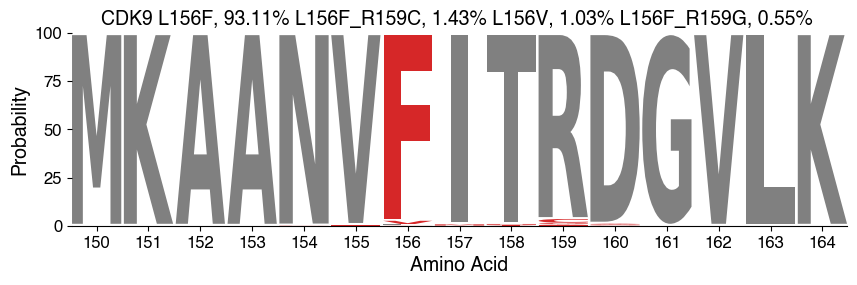

In [724]:
import logomaker


ss_logo = logomaker.Logo(logo_df, vpad = .02) #color_scheme='chemistry', vpad=.02)

# style using Logo methods
#ss_logo.highlight_position(p=min_cod, color='gold', alpha=.5)
#ss_logo.highlight_position(p=max_cod, color='gold', alpha=.5)

ss_logo.style_spines(spines=['left', 'right', 'top'], visible=False)

ss_logo.style_xticks(anchor=0, spacing=1, rotation=0, fontsize=12)
ss_logo.ax.set_yticks([0,25, 50, 75,100])
ss_logo.ax.set_yticklabels([0,25, 50, 75,100], fontsize=12);
ss_logo.ax.set_xlabel('Amino Acid', fontsize=14)
ss_logo.ax.set_ylabel('Probability', fontsize=14)

ss_logo.ax.get_xticks()

d_nonzero = d4[d4['corr_perc']>0]


for i, val in d_nonzero.iterrows():
    alt = val['alt']
    loc = val['codon']
    pp = val['corr_perc']
    ss_logo.style_single_glyph(c=alt, p=loc, color='tab:red')


s2 = ''

dd = d[(d['corr_perc']>0) & (d['HGVSp']!='WT')].sort_values(by='corr_perc', ascending=False)

for i, val in dd[:4].iterrows():
    pp = val['corr_perc']
    s2 += f"{val['HGVSp']}, {np.round(pp,2)}% "
g = merge.loc[merge['gRNA_id']==gRNA_id, 'Gene_x'].values[0]


ss_logo.ax.set_title(f'{g} {s2}', fontsize=14)


In [682]:
out1 = pd.read_csv('CBE_editing/HGVSp_quant/D24-257002-1-6959F_guide_split_BARCODES_redo_HGVSp_sensor_quant.csv')
out1

#extract_numbers('+4C>T,+6C>T')
possible_edits = ['C>T', 'C>G', 'C>A',
                  'A>G', 'A>C', 'A>T',
                  'G>C', 'G>A', 'G>T',
                  'T>C','T>A', 'T>G']

e = []
loc = []
for i, val in enumerate(possible_edits):
    arr = list(range(1,21))

    for k, val2 in enumerate(arr):
        e.append(val)
        loc.append(val2)

holding_df = pd.DataFrame(dict(zip(['Edit', 'Location', '#Reads'], [e, loc, np.zeros(240)])))

for i, val in out1.iterrows():
    dna = val['DNA Change']
    num_reads = val['#Reads']

    if dna != 'No edit':
        sp = [i for i in dna.split(',') if i!='']

        sp_nums = [extract_numbers(i) for i in sp]
        sp_edit = [i[-3:] for i in sp]

        for k, val in enumerate(sp_nums):
            holding_df.loc[(holding_df['Edit']==sp_edit[k]) & (holding_df['Location']==val), '#Reads']+=num_reads


<Axes: xlabel='Location', ylabel='#Reads'>

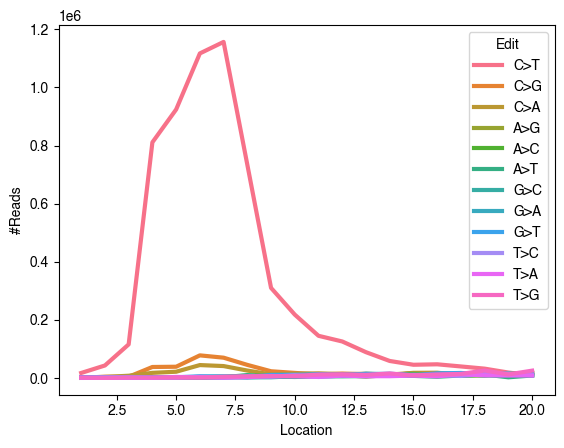

In [683]:
sns.lineplot(data = holding_df, x='Location', y='#Reads', hue='Edit', linewidth=3)

In [695]:
sum(out1[out1['gRNA_id']=='gRNA_CDK7_targ_2']['#Reads'])

1269

In [ ]:
holding_df['Total_possible_reads'] = 0

#and then also look at the number of available bases at each position to normalize
included_guides = master_pool1[master_pool1['gRNA_id'].isin(np.unique(out1['gRNA_id']))]


for i, val in included_guides.iterrows():
    protospacer = val['protospacer']
    gRNA_id = val['gRNA_id']
    total_reads = sum(out1[out1['gRNA_id']==gRNA_id]['#Reads'])

    for k, val2 in enumerate(protospacer):
        location = k+1

        if val2 == 'C':
            holding_df.loc[(holding_df['Edit']=='C>T') & (holding_df['Location']==location), 'Total_possible_reads']+=total_reads
            holding_df.loc[(holding_df['Edit']=='C>G') & (holding_df['Location']==location), 'Total_possible_reads']+=total_reads
            holding_df.loc[(holding_df['Edit']=='C>A') & (holding_df['Location']==location), 'Total_possible_reads']+=total_reads

        elif val2 == 'T':
            holding_df.loc[(holding_df['Edit']=='T>C') & (holding_df['Location']==location), 'Total_possible_reads']+=total_reads
            holding_df.loc[(holding_df['Edit']=='T>G') & (holding_df['Location']==location), 'Total_possible_reads']+=total_reads
            holding_df.loc[(holding_df['Edit']=='T>A') & (holding_df['Location']==location), 'Total_possible_reads']+=total_reads

        elif val2 == 'A':
            holding_df.loc[(holding_df['Edit']=='A>T') & (holding_df['Location']==location), 'Total_possible_reads']+=total_reads
            holding_df.loc[(holding_df['Edit']=='A>G') & (holding_df['Location']==location), 'Total_possible_reads']+=total_reads
            holding_df.loc[(holding_df['Edit']=='A>C') & (holding_df['Location']==location), 'Total_possible_reads']+=total_reads

        elif val2 == 'G':
            holding_df.loc[(holding_df['Edit']=='G>T') & (holding_df['Location']==location), 'Total_possible_reads']+=total_reads
            holding_df.loc[(holding_df['Edit']=='G>C') & (holding_df['Location']==location), 'Total_possible_reads']+=total_reads
            holding_df.loc[(holding_df['Edit']=='G>A') & (holding_df['Location']==location), 'Total_possible_reads']+=total_reads




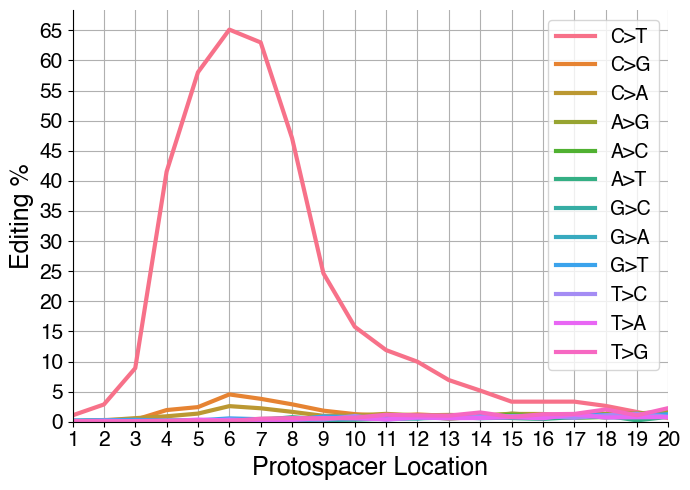

In [720]:
holding_df['%Reads'] = 100*(holding_df['#Reads']/holding_df['Total_possible_reads'])

fig, ax = plt.subplots(figsize=(7,5))
sns.lineplot(data = holding_df, x='Location', y='%Reads', hue='Edit', linewidth=3)

ax.spines[['right', 'top']].set_visible(False)
ax.set_xlim(1,20)
ax.set_ylim(0,)
ax.set_yticks([0,5,10,15,20,25,30,35,40,45,50,55,60,65])
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid()

ax.set_xlabel('Protospacer Location', fontsize=18)
ax.set_ylabel('Editing %', fontsize=18)
ax.legend(fontsize=14)
fig.tight_layout()

# Rerunning crispresso with dummy HDR

Running crispresso on ALL gRNAs with dummy variable for HDR template (sensor_wt), to quantify every editing event that occurs.



In [ ]:
lib_cluster = pd.read_csv('cluster_scripts/CDK_library_CLUSTER.csv')
targ_pool1_cluster = lib_cluster[(lib_cluster['Pool']=='F1-R1') & (lib_cluster['classification']=='targeting')].reset_index(drop=True)
dummy_sensor_alt = 'ATCGAT'*7
assert len(targ_pool1_cluster['sensor_wt'][0]) == len(dummy_sensor_alt)

targ_pool1_cluster['sensor_alt'] = dummy_sensor_alt
#targ_pool1_cluster.to_csv('cluster_scripts/CDK_pool1_targeting_dummy_sensor_alt.csv', index=False)

In [768]:
# making sure comparison is accurate/this works well
out1 = pd.read_csv('CBE_editing/HGVSp_quant/D24-257002-1-6959F_guide_split_BARCODES_redo_HGVSp_sensor_quant.csv')

out2 = pd.read_csv('CBE_editing/HGVSp_quant_full_v2/D24-257002-1-6959F_guide_split_BARCODES_redo_HGVSp_sensor_quant_v2.csv')

out1[out1['gRNA_id']==top_list[0]]

,Edit,#Reads,HGVSp,Num_edits,DNA Change,Canonical_edit,Canonical_window,gRNA_id
26276,ATGTGTTTATCACTCGTGAT,1440,L156F,1,"+6C>T,",True,True,gRNA_CDK9_targ_1200
26277,ATGTGTTTATTACTCGTGAT,893,L156F,2,"+6C>T,+11C>T,",True,False,gRNA_CDK9_targ_1200
26278,ATGTGTTTATCACTTGTGAT,26,L156F_R159C,2,"+6C>T,+15C>T,",True,False,gRNA_CDK9_targ_1200
26279,ATGTGGTTATCACTCGTGAT,14,L156V,1,"+6C>G,",False,True,gRNA_CDK9_targ_1200
26280,ATGTGTTTATCACTGGTGAT,12,L156F_R159G,2,"+6C>T,+15C>G,",False,False,gRNA_CDK9_targ_1200
...,...,...,...,...,...,...,...,...
26332,ATGTGTTTATCACTCGATCA,1,L156F_D160S,5,"+6C>T,+17T>A,+18G>T,+19A>C,+20T>A,",False,False,gRNA_CDK9_targ_1200
26333,AGGTGTTTATCACTCGTGAT,1,N154K_L156F,2,"+2T>G,+6C>T,",False,False,gRNA_CDK9_targ_1200
26334,ATGTGTTTATCACTCGTGAC,1,L156F,2,"+6C>T,+20T>C,",False,False,gRNA_CDK9_targ_1200
26335,ATGTGTTTATCACTCGTGAG,1,L156F_D160E,2,"+6C>T,+20T>G,",False,False,gRNA_CDK9_targ_1200


# Processing new output

In [870]:
output = sorted(os.listdir('CBE_editing/HGVSp_quant_full_v2'))

name_dict = {'D24-257001' : 'Plasmid',
'D24-257002' : 'T0_REP1',
'D24-257003' : 'T0_REP2',
'D24-257004' : 'DMSO_REP1', 
'D24-257005' : 'DMSO_REP2', 
'D24-257006' : 'DMSO_REP3', 
'D24-257007' : 'KI-CDK9d-32_100nM_REP1', 
'D24-257008' : 'KI-CDK9d-32_100nM_REP2',
'D24-257009' : 'KI-CDK9d-32_100nM_REP3',
'D24-257010' : 'KI-CDK9d-32_1000nM_REP1', 
'D24-257011' : 'KI-CDK9d-32_1000nM_REP2', 
'D24-257012' : 'KI-CDK9d-32_1000nM_REP3', 
'D24-257013' : 'KI-CDK9d-32N_1250nM_REP1', 
'D24-257014' : 'KI-CDK9d-32N_1250nM_REP2', 
'D24-257015' : 'KI-CDK9d-32N_1250nM_REP3', 
'D24-257016' : 'KI-CDK9d-32N_5000nM_REP1', 
'D24-257017' : 'KI-CDK9d-32N_5000nM_REP2', 
'D24-257018' : 'KI-CDK9d-32N_5000nM_REP3', 
'D24-257019' : 'KB-0742_1500nM_REP1', 
'D24-257020' : 'KB-0742_1500nM_REP2', 
'D24-257021' : 'KB-0742_1500nM_REP3', 
'D24-257022' : 'Senexin_B_2000nM_REP1', 
'D24-257023' : 'Senexin_B_2000nM_REP2',
'D24-257024' : 'Senexin_B_2000nM_REP3',
'D24-257025' : 'Senexin_B_15000nM_REP1',
'D24-257026' : 'Senexin_B_15000nM_REP2',
'D24-257027' : 'Senexin_B_15000nM_REP3', 
'D24-257028' : 'SEL120_4000nM_REP1',
'D24-257029' : 'SEL120_4000nM_REP2', 
'D24-257030' : 'SEL120_4000nM_REP3',}

plasmid = output[:2]

all_samples = output[2:]


def HGVSp_combiner(file_name_list):

    fp = 'CBE_editing/HGVSp_quant_full_v2'

    df_holder = []
    for k in file_name_list:
        d = pd.read_csv(f'{fp}/{k}')
        df_holder.append(d)

    #and the combining
    new_out = pd.concat(df_holder).groupby(['Edit', 'HGVSp', 'Num_edits', 'DNA Change', 'Canonical_edit', 'Canonical_window', 'gRNA_id']).sum().reset_index().sort_values(['gRNA_id', '#Reads'], ascending=[True, False]).reset_index(drop=True)

    hgvsp_only = new_out[['gRNA_id', 'HGVSp', '#Reads']].groupby(['gRNA_id', 'HGVSp'], as_index=False).sum().sort_values(['gRNA_id', '#Reads'], ascending=[True, False]).reset_index(drop=True)

    return new_out, hgvsp_only


plasmid_combined, plasmid_hgvsp_only = HGVSp_combiner(plasmid)
all_combined, all_hgvsp_only = HGVSp_combiner(all_samples)

In [981]:
#and adding percentage information
#then generate the percentages for each gRNA
def perc_adder(list_of_gRNAs, df):

    holder = []
    for i in list_of_gRNAs:

        sub = df[df['gRNA_id']==i]
        if len(sub)>0:
            sub['%Reads'] = 100*sub['#Reads']/sum(sub['#Reads'])
            holder.append(sub)

    df_new = pd.concat(holder).reset_index(drop=True)

    return df_new

lib_cluster = pd.read_csv('cluster_scripts/CDK_library_CLUSTER.csv')
targ_pool1_cluster = lib_cluster[(lib_cluster['Pool']=='F1-R1') & (lib_cluster['classification']=='targeting')].reset_index(drop=True)
list_of_gRNAs = list(targ_pool1_cluster['gRNA_id'])



all_combined2 = perc_adder(list_of_gRNAs, all_combined)
all_hgvsp_only2 = perc_adder(list_of_gRNAs, all_hgvsp_only)
plasmid_combined2 = perc_adder(list_of_gRNAs, plasmid_combined)
plasmid_hgvsp_only2 = perc_adder(list_of_gRNAs, plasmid_hgvsp_only)

In [ ]:
#saving tables as zip files (for storage considerations)
filename = 'CBE_editing/all_samples_combined_edit'
compression_options = dict(method='zip', archive_name=f'{filename}.csv')
#all_combined2.to_csv(f'{filename}.zip', compression=compression_options, index=False)

filename = 'CBE_editing/all_samples_combined_HGVSp_only'
compression_options = dict(method='zip', archive_name=f'{filename}.csv')
#all_hgvsp_only2.to_csv(f'{filename}.zip', compression=compression_options, index=False)

filename = 'CBE_editing/plasmid_combined_edit'
compression_options = dict(method='zip', archive_name=f'{filename}.csv')
#plasmid_combined2.to_csv(f'{filename}.zip', compression=compression_options, index=False)

filename = 'CBE_editing/plasmid_combined_HGVSp_only'
compression_options = dict(method='zip', archive_name=f'{filename}.csv')
#plasmid_hgvsp_only2.to_csv(f'{filename}.zip', compression=compression_options, index=False)


# Analyzing editing

In [995]:
all_combined = pd.read_csv('CBE_editing/all_samples_combined_edit.zip')
all_hgvsp_only = pd.read_csv('CBE_editing/all_samples_combined_HGVSp_only.zip')
plasmid_combined = pd.read_csv('CBE_editing/plasmid_combined_edit.zip')
plasmid_hgvsp_only = pd.read_csv('CBE_editing/plasmid_combined_HGVSp_only.zip')

In [ ]:
#first do the plasmid library

out1 = plasmid_combined

#extract_numbers('+4C>T,+6C>T')
possible_edits = ['C>T', 'C>G', 'C>A',
                  'A>G', 'A>C', 'A>T',
                  'G>C', 'G>A', 'G>T',
                  'T>C','T>A', 'T>G']

e = []
loc = []
for i, val in enumerate(possible_edits):
    arr = list(range(1,21))

    for k, val2 in enumerate(arr):
        e.append(val)
        loc.append(val2)

holding_df = pd.DataFrame(dict(zip(['Edit', 'Location', '#Reads'], [e, loc, np.zeros(240)])))

for i, val in out1.iterrows():
    dna = val['DNA Change']
    num_reads = val['#Reads']

    if dna != 'No edit':
        sp = [i for i in dna.split(',') if i!='']

        sp_nums = [extract_numbers(i) for i in sp]
        sp_edit = [i[-3:] for i in sp]

        for k, val in enumerate(sp_nums):
            holding_df.loc[(holding_df['Edit']==sp_edit[k]) & (holding_df['Location']==val), '#Reads']+=num_reads

holding_df['Total_possible_reads'] = 0

#and then also look at the number of available bases at each position to normalize
lib_cluster = pd.read_csv('cluster_scripts/CDK_library_CLUSTER.csv')
master_pool1 = lib_cluster[(lib_cluster['Pool']=='F1-R1') & (lib_cluster['classification']=='targeting')].reset_index(drop=True)
included_guides = master_pool1[master_pool1['gRNA_id'].isin(np.unique(out1['gRNA_id']))]


for i, val in included_guides.iterrows():
    protospacer = val['protospacer']
    gRNA_id = val['gRNA_id']
    total_reads = sum(out1[out1['gRNA_id']==gRNA_id]['#Reads'])

    for k, val2 in enumerate(protospacer):
        location = k+1

        if val2 == 'C':
            holding_df.loc[(holding_df['Edit']=='C>T') & (holding_df['Location']==location), 'Total_possible_reads']+=total_reads
            holding_df.loc[(holding_df['Edit']=='C>G') & (holding_df['Location']==location), 'Total_possible_reads']+=total_reads
            holding_df.loc[(holding_df['Edit']=='C>A') & (holding_df['Location']==location), 'Total_possible_reads']+=total_reads

        elif val2 == 'T':
            holding_df.loc[(holding_df['Edit']=='T>C') & (holding_df['Location']==location), 'Total_possible_reads']+=total_reads
            holding_df.loc[(holding_df['Edit']=='T>G') & (holding_df['Location']==location), 'Total_possible_reads']+=total_reads
            holding_df.loc[(holding_df['Edit']=='T>A') & (holding_df['Location']==location), 'Total_possible_reads']+=total_reads

        elif val2 == 'A':
            holding_df.loc[(holding_df['Edit']=='A>T') & (holding_df['Location']==location), 'Total_possible_reads']+=total_reads
            holding_df.loc[(holding_df['Edit']=='A>G') & (holding_df['Location']==location), 'Total_possible_reads']+=total_reads
            holding_df.loc[(holding_df['Edit']=='A>C') & (holding_df['Location']==location), 'Total_possible_reads']+=total_reads

        elif val2 == 'G':
            holding_df.loc[(holding_df['Edit']=='G>T') & (holding_df['Location']==location), 'Total_possible_reads']+=total_reads
            holding_df.loc[(holding_df['Edit']=='G>C') & (holding_df['Location']==location), 'Total_possible_reads']+=total_reads
            holding_df.loc[(holding_df['Edit']=='G>A') & (holding_df['Location']==location), 'Total_possible_reads']+=total_reads


In [1001]:
#and then the edit library
out1 = all_combined

#extract_numbers('+4C>T,+6C>T')
possible_edits = ['C>T', 'C>G', 'C>A',
                  'A>G', 'A>C', 'A>T',
                  'G>C', 'G>A', 'G>T',
                  'T>C','T>A', 'T>G']

e = []
loc = []
for i, val in enumerate(possible_edits):
    arr = list(range(1,21))

    for k, val2 in enumerate(arr):
        e.append(val)
        loc.append(val2)

holding_df2 = pd.DataFrame(dict(zip(['Edit', 'Location', '#Reads'], [e, loc, np.zeros(240)])))

for i, val in out1.iterrows():
    dna = val['DNA Change']
    num_reads = val['#Reads']

    if dna != 'No edit':
        sp = [i for i in dna.split(',') if i!='']

        sp_nums = [extract_numbers(i) for i in sp]
        sp_edit = [i[-3:] for i in sp]

        for k, val in enumerate(sp_nums):
            holding_df2.loc[(holding_df2['Edit']==sp_edit[k]) & (holding_df2['Location']==val), '#Reads']+=num_reads

holding_df2['Total_possible_reads'] = 0

#and then also look at the number of available bases at each position to normalize
lib_cluster = pd.read_csv('cluster_scripts/CDK_library_CLUSTER.csv')
master_pool1 = lib_cluster[(lib_cluster['Pool']=='F1-R1') & (lib_cluster['classification']=='targeting')].reset_index(drop=True)
included_guides = master_pool1[master_pool1['gRNA_id'].isin(np.unique(out1['gRNA_id']))]


for i, val in included_guides.iterrows():
    protospacer = val['protospacer']
    gRNA_id = val['gRNA_id']
    total_reads = sum(out1[out1['gRNA_id']==gRNA_id]['#Reads'])

    for k, val2 in enumerate(protospacer):
        location = k+1

        if val2 == 'C':
            holding_df2.loc[(holding_df2['Edit']=='C>T') & (holding_df2['Location']==location), 'Total_possible_reads']+=total_reads
            holding_df2.loc[(holding_df2['Edit']=='C>G') & (holding_df2['Location']==location), 'Total_possible_reads']+=total_reads
            holding_df2.loc[(holding_df2['Edit']=='C>A') & (holding_df2['Location']==location), 'Total_possible_reads']+=total_reads

        elif val2 == 'T':
            holding_df2.loc[(holding_df2['Edit']=='T>C') & (holding_df2['Location']==location), 'Total_possible_reads']+=total_reads
            holding_df2.loc[(holding_df2['Edit']=='T>G') & (holding_df2['Location']==location), 'Total_possible_reads']+=total_reads
            holding_df2.loc[(holding_df2['Edit']=='T>A') & (holding_df2['Location']==location), 'Total_possible_reads']+=total_reads

        elif val2 == 'A':
            holding_df2.loc[(holding_df2['Edit']=='A>T') & (holding_df2['Location']==location), 'Total_possible_reads']+=total_reads
            holding_df2.loc[(holding_df2['Edit']=='A>G') & (holding_df2['Location']==location), 'Total_possible_reads']+=total_reads
            holding_df2.loc[(holding_df2['Edit']=='A>C') & (holding_df2['Location']==location), 'Total_possible_reads']+=total_reads

        elif val2 == 'G':
            holding_df2.loc[(holding_df2['Edit']=='G>T') & (holding_df2['Location']==location), 'Total_possible_reads']+=total_reads
            holding_df2.loc[(holding_df2['Edit']=='G>C') & (holding_df2['Location']==location), 'Total_possible_reads']+=total_reads
            holding_df2.loc[(holding_df2['Edit']=='G>A') & (holding_df2['Location']==location), 'Total_possible_reads']+=total_reads


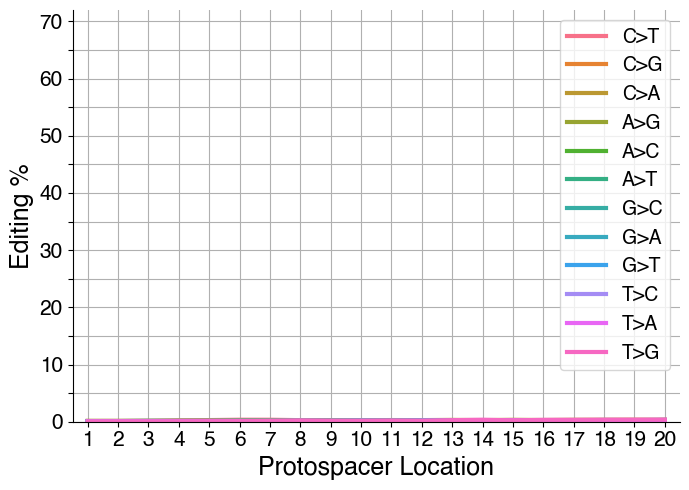

In [ ]:
#and plotting it

holding_df['%Reads'] = 100*(holding_df['#Reads']/holding_df['Total_possible_reads'])

fig, ax = plt.subplots(figsize=(7,5))
sns.lineplot(data = holding_df, x='Location', y='%Reads', hue='Edit', linewidth=3)

ax.spines[['right', 'top']].set_visible(False)
ax.set_xlim(.5,20.5)
ax.set_ylim(0,72)
ax.set_yticks([0,5,10,15,20,25,30,35,40,45,50,55,60,65, 70])
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
ax.set_yticklabels([0,'',10,'', 20, '', 30, '', 40, '', 50, '', 60, '',  70])

ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid()

ax.set_xlabel('Protospacer Location', fontsize=18)
ax.set_ylabel('Editing %', fontsize=18)
ax.legend(fontsize=14)
fig.tight_layout()
#fig.savefig('figures/avg_editing_plasmid.pdf')

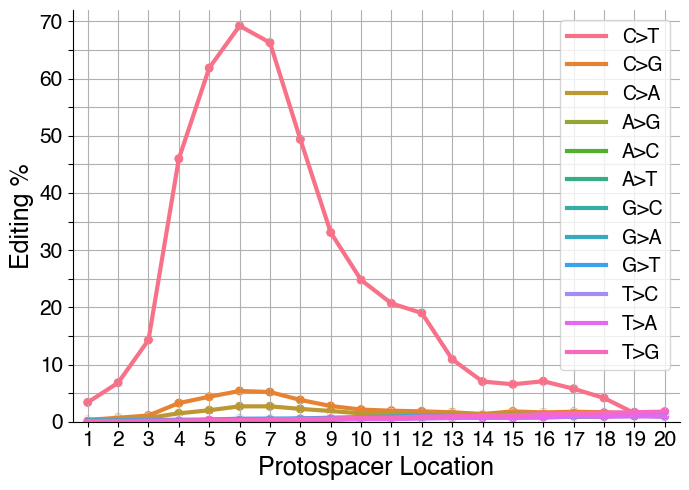

In [ ]:
#and plotting it

holding_df2['%Reads'] = 100*(holding_df2['#Reads']/holding_df2['Total_possible_reads'])

fig, ax = plt.subplots(figsize=(7,5))
sns.lineplot(data = holding_df2, x='Location', y='%Reads', hue='Edit', linewidth=3)
sns.scatterplot(data = holding_df2, x='Location', y='%Reads', hue='Edit', s=50, legend=False)

ax.spines[['right', 'top']].set_visible(False)
ax.set_xlim(.5,20.5)
ax.set_ylim(0,72)
ax.set_yticks([0,5,10,15,20,25,30,35,40,45,50,55,60,65, 70])
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
ax.set_yticklabels([0,'',10,'', 20, '', 30, '', 40, '', 50, '', 60, '',  70])
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid()

ax.set_xlabel('Protospacer Location', fontsize=18)
ax.set_ylabel('Editing %', fontsize=18)
ax.legend(fontsize=14)
fig.tight_layout()
#fig.savefig('figures/avg_editing.pdf')

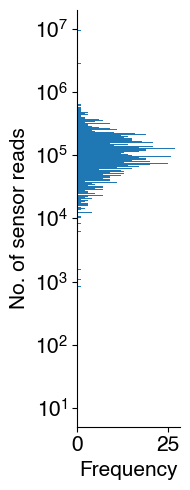

In [ ]:
sensor_reads = all_combined[['gRNA_id', '#Reads']].groupby('gRNA_id').sum().reset_index()
fig, ax = plt.subplots(figsize=(2,5))

logbins = np.logspace(np.log10(10),np.log10(1e7),1000)

ax.hist(sensor_reads['#Reads'], bins = logbins, orientation="horizontal")

ax.set_yscale('symlog')

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Frequency', fontsize=15)
ax.set_ylabel('No. of sensor reads', fontsize=15)
fig.tight_layout()
#fig.savefig('figures/no_sensor_reads.pdf')

In [1096]:
total_reads = sum(all_combined['#Reads'])


no_edit_reads = 100*sum(all_combined[all_combined['DNA Change']=='No edit']['#Reads'])/total_reads
canonical = 100*sum(all_combined[(all_combined['Canonical_window']==True) & (all_combined['Canonical_edit']==True) & (all_combined['DNA Change']!='No edit')]['#Reads'])/total_reads
noncanonical = 100*sum(all_combined[(all_combined['Canonical_window']==False) | (all_combined['Canonical_edit']==False) & (all_combined['DNA Change']!='No edit')]['#Reads'])/total_reads


outside_window = 100*sum(all_combined[(all_combined['Canonical_window']==False) & (all_combined['Canonical_edit']==True) & (all_combined['DNA Change']!='No edit')]['#Reads'])/total_reads
non_canonical_outside = 100*sum(all_combined[(all_combined['Canonical_window']==False) & (all_combined['Canonical_edit']==False) & (all_combined['DNA Change']!='No edit')]['#Reads'])/total_reads
non_canonical_inside = 100*sum(all_combined[(all_combined['Canonical_window']==True) & (all_combined['Canonical_edit']==False) & (all_combined['DNA Change']!='No edit')]['#Reads'])/total_reads


ns = ['No Edit', 'Predicted Edit', 'Unpredicted Edit', 'Canonical, Outside +4 to +8', 'Non-canonical, Inside +4 to +8', 'Non-canonical, Outside +4 to +8']
percs = [no_edit_reads, canonical, noncanonical, outside_window, non_canonical_inside, non_canonical_outside]
pd.DataFrame(dict(zip(['Edit Classifiaction', '% of Sensor Reads'], [ns, percs])))

,Edit Classifiaction,% of Sensor Reads
0,No Edit,19.065986
1,Predicted Edit,32.441531
2,Unpredicted Edit,48.492483
3,"Canonical, Outside +4 to +8",30.461344
4,"Non-canonical, Inside +4 to +8",6.241556
5,"Non-canonical, Outside +4 to +8",11.789583


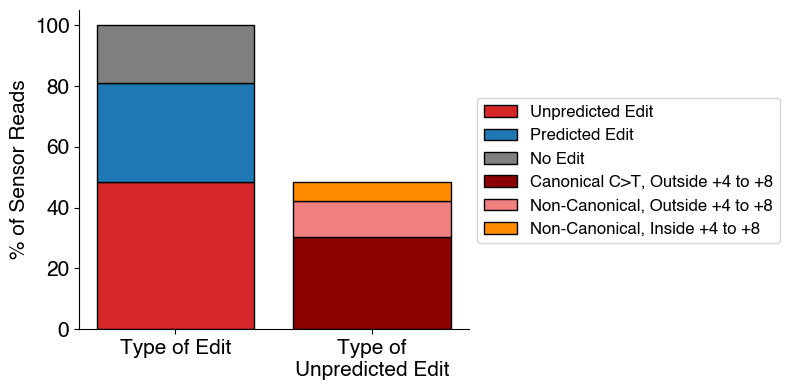

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

ax.bar(['Type of Edit'], noncanonical, linewidth=1, edgecolor='black', label='Unpredicted Edit', color='tab:red')
ax.bar(['Type of Edit'], canonical, bottom = noncanonical, linewidth=1, edgecolor='black', label='Predicted Edit', color='tab:blue')
ax.bar(['Type of Edit'], no_edit_reads, bottom = noncanonical+canonical, linewidth=1, edgecolor='black', label='No Edit', color='tab:grey')


ax.bar(['Type of\nUnpredicted Edit'], outside_window, linewidth=1, edgecolor='black',label='Canonical C>T, Outside +4 to +8', color='darkred')
ax.bar(['Type of\nUnpredicted Edit'], non_canonical_outside, bottom = outside_window, linewidth=1, edgecolor='black',label='Non-Canonical, Outside +4 to +8', color='lightcoral')
ax.bar(['Type of\nUnpredicted Edit'], non_canonical_inside, bottom = outside_window+non_canonical_outside, linewidth=1, edgecolor='black',label='Non-Canonical, Inside +4 to +8', color='darkorange')

ax.legend(fontsize=12, bbox_to_anchor=[1, 0.75])

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)

ax.set_ylabel('% of Sensor Reads', fontsize=15)

fig.tight_layout()
#fig.savefig('figures/summary_stacked_bar_edit.pdf')

In [ ]:
cdk7_edits = pd.read_csv('edit_')
cdk9_edits = pd.read_csv('edit_libraries/CDK9_edits.csv')


Index(['gRNA_id', 'Gene', 'protospacer', 'Protospacer', 'chrom', 'exon',
       'proto_start', 'proto_end', 'PAM', 'PAM_start', 'PAM_end',
       'ideal_start', 'ideal_end', 'ideal_window', 'strand', 'sensor_wt',
       'CDS_hit', 'ABE_amenable', 'CBE_amenable', 'classification',
       'nearest_exon_distance', 'Pool', 'Hamming_BC', 'gRNA_oligo', 'RE_sites',
       'gRNA_id_OLD'],
      dtype='object')

In [ ]:
edits = pd.read_csv('cluster_scripts/CDK_edits_CBE_pool1.csv')
non_wt_edits = edits[edits['HGVSp']!='WT'].reset_index(drop=True).rename(columns={'Gene_x':'Gene'})

nonwt_uniq = non_wt_edits[['Gene', 'HGVSp', 'Complex', 'Codon', 'WT_AA', 'MUT_AA']].drop_duplicates().reset_index(drop=True)
nonwt_uniq['Observed'] = False
nonwt_uniq['Num_guides_observed'] = 0
nonwt_uniq

,Gene,HGVSp,Complex,Codon,WT_AA,MUT_AA,Observed,Num_guides_observed
0,CDK7,A2V,False,2.0,A,V,False,0
1,CDK7,S7F,False,7.0,S,F,False,0
2,CDK7,R8W,False,8.0,R,W,False,0
3,CDK7,S7F_R8W,True,NaN,NaN,NaN,False,0
4,CDK7,A9V,False,9.0,A,V,False,0
...,...,...,...,...,...,...,...,...
1547,CDK19,R13W,False,13.0,R,W,False,0
1548,CDK19,A11V,False,11.0,A,V,False,0
1549,CDK19,A10V,False,10.0,A,V,False,0
1550,CDK19,A10V_A11V,True,NaN,NaN,NaN,False,0


In [1289]:
edits = pd.read_csv('cluster_scripts/CDK_edits_CBE_pool1.csv')
non_wt_edits = edits[edits['HGVSp']!='WT'].reset_index(drop=True).rename(columns={'Gene_x':'Gene'})

nonwt_uniq = non_wt_edits[['Gene', 'HGVSp', 'Complex', 'Codon', 'WT_AA', 'MUT_AA']].drop_duplicates().reset_index(drop=True)
nonwt_uniq['Observed'] = False
nonwt_uniq['Num_guides_observed'] = 0
nonwt_uniq['Predicted'] = True

#---------and determine if they're observed----------
edit_cutoff = 20


thresh = all_hgvsp_only[(all_hgvsp_only['%Reads']>=edit_cutoff) & (all_hgvsp_only['HGVSp']!='WT')].reset_index(drop=True)
thresh['Gene'] = [i.split('_')[1] for i in thresh['gRNA_id']]
complex = []
for i, val in thresh.iterrows():
    h = val['HGVSp']
    if '_' in h:
        complex.append(True)
    else:
        complex.append(False)

thresh['Complex'] = complex


not_predicted = []

for i, val in thresh.iterrows():
    g = val['Gene']
    h = val['HGVSp']

    subset = nonwt_uniq[(nonwt_uniq['Gene']==g) & (nonwt_uniq['HGVSp']==h)]

    if len(subset)>0:
        nonwt_uniq.loc[(nonwt_uniq['Gene']==g) & (nonwt_uniq['HGVSp']==h), 'Observed']=True
        nonwt_uniq.loc[(nonwt_uniq['Gene']==g) & (nonwt_uniq['HGVSp']==h), 'Num_guides_observed']+=1
    else:
        not_predicted.append(thresh.iloc[[i]])

unpredicted = pd.concat(not_predicted)[['Gene', 'HGVSp', 'Complex']].drop_duplicates()
unpredicted['Predicted'] = False

codon = []
wt_aa = []
mut_aa = []
for i, val in unpredicted.iterrows():
    c = val['Complex']
    if c==True:
        codon.append(None)
        wt_aa.append(None)
        mut_aa.append(None)
    elif c==False:
        h = val['HGVSp']
        wt = h[0]
        mut = h[-1]
        wt_aa.append(wt)
        mut_aa.append(mut)

        cod_num = extract_numbers(h)
        codon.append(int(cod_num))

unpredicted['Codon'] = codon
unpredicted['WT_AA'] = wt_aa
unpredicted['MUT_AA'] = mut_aa


In [1290]:
genes = ['CDK7', 'CDK8', 'CDK9', 'CDK19']
plot_df = pd.DataFrame(dict(zip(['Gene', '# Predicted Variants', '# Predicted Variants Observed', '# Novel Variants Observed', 
                                 '# Predicted Codons', '# Predicted Codons Observed', '# Codons Observed'], 
                                [genes, np.zeros(4), np.zeros(4), np.zeros(4), np.zeros(4), np.zeros(4), np.zeros(4)])))

for gene in genes:
    subset = nonwt_uniq[nonwt_uniq['Gene']==gene]
    num = len(subset)
    plot_df.loc[plot_df['Gene']==gene, '# Predicted Variants'] = num

    num_observed = len(subset[subset['Observed']==True])
    plot_df.loc[plot_df['Gene']==gene, '# Predicted Variants Observed'] = num_observed

    #and novel variants
    subset2 = unpredicted[unpredicted['Gene'] == gene]
    plot_df.loc[plot_df['Gene']==gene, '# Novel Variants Observed'] = len(subset2)

    #and codon observation, for SIMPLE variants only
    plot_df.loc[plot_df['Gene']==gene, '# Predicted Codons'] = len(np.unique(subset[subset['Complex']==False]['Codon']))

    #and then num codons observed

    #first predicted
    plot_df.loc[plot_df['Gene']==gene, '# Predicted Codons Observed'] = len(np.unique(subset[(subset['Complex']==False) & (subset['Observed']==True)]['Codon']))


    #and then all
    subset3 = pd.concat((subset[subset['Complex']==False], subset2[subset2['Complex']==False]))
    plot_df.loc[plot_df['Gene']==gene, '# Codons Observed'] = len(np.unique(subset3[subset3['Complex']==False]['Codon']))


plot_df['# Novel Codons Observed'] = plot_df['# Codons Observed'] - plot_df['# Predicted Codons Observed'] 
plot_df['Protein Length'] = [352, 472, 379, 511]
plot_df

,Gene,# Predicted Variants,# Predicted Variants Observed,# Novel Variants Observed,# Predicted Codons,# Predicted Codons Observed,# Codons Observed,# Novel Codons Observed,Protein Length
0,CDK7,248.0,144.0,42.0,153.0,115.0,169.0,54.0,352
1,CDK8,426.0,221.0,53.0,231.0,164.0,245.0,81.0,472
2,CDK9,397.0,238.0,46.0,211.0,165.0,220.0,55.0,379
3,CDK19,481.0,259.0,73.0,253.0,191.0,267.0,76.0,511


In [1291]:
plot_df['% AAs Predicted Mutated'] = 100*plot_df['# Predicted Codons']/plot_df['Protein Length']
plot_df['% AAs Predicted AND Observed Mutated'] = 100*plot_df['# Predicted Codons Observed']/plot_df['Protein Length']
plot_df['% AAs Observed Mutated'] = 100*plot_df['# Codons Observed']/plot_df['Protein Length']
plot_df

,Gene,# Predicted Variants,# Predicted Variants Observed,# Novel Variants Observed,# Predicted Codons,# Predicted Codons Observed,# Codons Observed,# Novel Codons Observed,Protein Length,% AAs Predicted Mutated,% AAs Predicted AND Observed Mutated,% AAs Observed Mutated
0,CDK7,248.0,144.0,42.0,153.0,115.0,169.0,54.0,352,43.465909,32.670455,48.011364
1,CDK8,426.0,221.0,53.0,231.0,164.0,245.0,81.0,472,48.940678,34.745763,51.906780
2,CDK9,397.0,238.0,46.0,211.0,165.0,220.0,55.0,379,55.672823,43.535620,58.047493
3,CDK19,481.0,259.0,73.0,253.0,191.0,267.0,76.0,511,49.510763,37.377691,52.250489


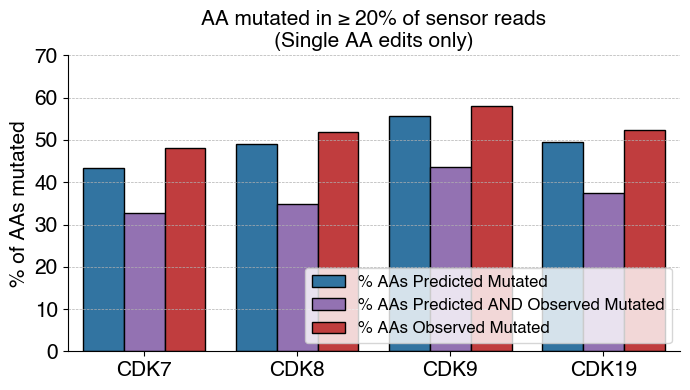

In [1292]:
melted = plot_df.melt(id_vars='Gene', value_vars = plot_df.columns[1:])

melted1 = melted[melted['variable'].isin(['% AAs Predicted Mutated',
       '% AAs Predicted AND Observed Mutated', '% AAs Observed Mutated'])]
fig, ax  = plt.subplots(figsize=(7,4))

sns.barplot(data=melted1, x='Gene', y='value', hue='variable', linewidth=1, edgecolor='black', palette=['tab:blue', 'tab:purple', 'tab:red', 'black'], ax=ax)
#ax.legend(fontsize=12, bbox_to_anchor=[1, 0.75])
ax.legend(fontsize=12, loc='lower right')
ax.set_yticks([0,10,20,30,40,50,60,70])
ax.grid(axis='y', linewidth=.5, linestyle='dashed')
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)

ax.set_ylabel('% of AAs mutated', fontsize=15)
ax.set_xlabel('')
ax.set_title(f'AA mutated in ≥ {edit_cutoff}% of sensor reads\n(Single AA edits only)', fontsize=15)
fig.tight_layout()
fig.savefig(f'figures/aa_frac_mutated_cutoff_{edit_cutoff}.pdf')

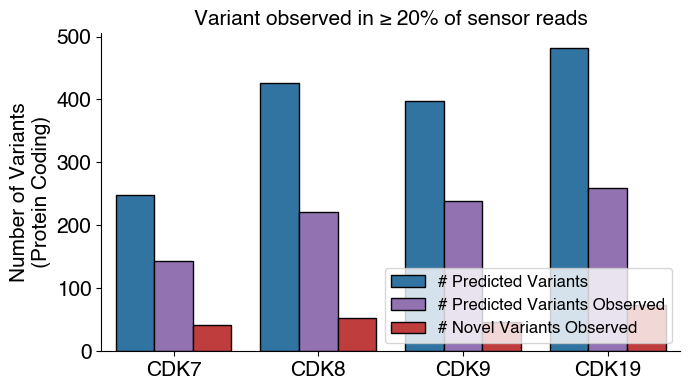

In [1293]:
melted = plot_df.melt(id_vars='Gene', value_vars = plot_df.columns[1:])

melted2 = melted[melted['variable'].isin(['# Predicted Variants', '# Predicted Variants Observed', '# Novel Variants Observed'])]
fig, ax  = plt.subplots(figsize=(7,4))

sns.barplot(data=melted2, x='Gene', y='value', hue='variable', linewidth=1, edgecolor='black', palette=['tab:blue', 'tab:purple', 'tab:red'], ax=ax)
#ax.legend(fontsize=12, bbox_to_anchor=[1, 0.75])
ax.legend(fontsize=12, loc='lower right')

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)

ax.set_ylabel('Number of Variants\n(Protein Coding)', fontsize=15)
ax.set_xlabel('')
ax.set_title(f'Variant observed in ≥ {edit_cutoff}% of sensor reads', fontsize=15)
fig.tight_layout()
fig.savefig(f'figures/vars_observed_{edit_cutoff}_cutoff.pdf')

In [1198]:
nonwt_uniq

,Gene,HGVSp,Complex,Codon,WT_AA,MUT_AA,Observed,Num_guides_observed,Predicted
0,CDK7,A2V,False,2.0,A,V,True,3,True
1,CDK7,S7F,False,7.0,S,F,True,5,True
2,CDK7,R8W,False,8.0,R,W,True,1,True
3,CDK7,S7F_R8W,True,NaN,NaN,NaN,True,2,True
4,CDK7,A9V,False,9.0,A,V,True,1,True
...,...,...,...,...,...,...,...,...,...
1547,CDK19,R13W,False,13.0,R,W,True,2,True
1548,CDK19,A11V,False,11.0,A,V,True,3,True
1549,CDK19,A10V,False,10.0,A,V,True,4,True
1550,CDK19,A10V_A11V,True,NaN,NaN,NaN,True,4,True


In [958]:
total_reads = sum(all_combined['#Reads'])

canonical_edits = sum(all_combined[(all_combined['Canonical_edit']==True)]['#Reads'])
non_canonical_edits = sum(all_combined[all_combined['Canonical_edit']==False]['#Reads'])
canonical_window = sum(all_combined[all_combined['Canonical_window']==True]['#Reads'])
non_canonical_window = sum(all_combined[all_combined['Canonical_window']==False]['#Reads'])
both_canonical = sum(all_combined[(all_combined['Canonical_window']==True) & (all_combined['Canonical_edit']==True)]['#Reads'])
print(100*canonical_edits/total_reads)
print(100*non_canonical_edits/total_reads)
print(100*canonical_window/total_reads)
print(100*non_canonical_window/total_reads)
print(100*both_canonical/total_reads)

81.9688614453483
18.0311385546517
57.749073127724664
42.250926872275336
51.50751717235997


In [965]:
total_reads = sum(plasmid_combined['#Reads'])

canonical_edits = sum(plasmid_combined[(plasmid_combined['Canonical_edit']==True)]['#Reads'])
non_canonical_edits = sum(plasmid_combined[plasmid_combined['Canonical_edit']==False]['#Reads'])
canonical_window = sum(plasmid_combined[plasmid_combined['Canonical_window']==True]['#Reads'])
non_canonical_window = sum(plasmid_combined[plasmid_combined['Canonical_window']==False]['#Reads'])
both_canonical = sum(plasmid_combined[(plasmid_combined['Canonical_window']==True) & (plasmid_combined['Canonical_edit']==True)]['#Reads'])
no_change = sum(plasmid_combined[plasmid_combined['DNA Change']=='No edit']['#Reads'])
print(100*canonical_edits/total_reads)
print(100*non_canonical_edits/total_reads)
print(100*canonical_window/total_reads)
print(100*non_canonical_window/total_reads)
print(100*both_canonical/total_reads)
print(100*no_change/total_reads)

96.07099883779276
3.9290011622072414
96.51671991805347
3.48328008194653
95.8834327449851
95.74346531415249


In [963]:
plasmid_combined

,Edit,HGVSp,Num_edits,DNA Change,Canonical_edit,Canonical_window,gRNA_id,#Reads
0,TGGTCAGTACCGGTGGGCCT,WT,20,No edit,True,True,gRNA_CDK19_targ_6273,3714
1,TGGTCAGTACCGGGGGGCCT,H500P,20,"+14T>G,",False,False,gRNA_CDK19_targ_6273,100
2,TGGTCAGTACCGGTGGGCCG,Q498P,20,"+20T>G,",False,False,gRNA_CDK19_targ_6273,76
3,TGGTCAGTACCGGTGGACCT,A499V,20,"+17G>A,",False,False,gRNA_CDK19_targ_6273,15
4,CTGGTCAGTACCGGTGGGCC,Q498R_A499P_H500T_R501G_Y502T,20,"+1T>C,+2G>T,+4T>G,+5C>T,+6A>C,+7G>A,+8T>G,+9A>...",False,False,gRNA_CDK19_targ_6273,12
...,...,...,...,...,...,...,...,...
129647,CGGAAGACGCGCTCAAACTC,WT,20,"+2A>G,",False,False,gRNA_CDK9_targ_1739,1
129648,GAAGAAGACGCGCTCAAACT,E367S_F368L_E369S_R370A_V371S_F372S,20,"+1C>G,+3G>A,+4A>G,+6G>A,+7A>G,+8C>A,+9G>C,+10C...",False,False,gRNA_CDK9_targ_1739,1
129649,TAGAAGACGCGCTCAAACTC,WT,20,"+1C>T,",True,False,gRNA_CDK9_targ_1739,1
129650,TAGAAGACGCGCTTAAACTC,E369K,20,"+1C>T,+14C>T,",True,False,gRNA_CDK9_targ_1739,1


In [961]:
tr = sum(all_combined[all_combined['#Reads']>100]['#Reads'])
canonical_edits = sum(all_combined[(all_combined['Canonical_edit']==True) & (all_combined['#Reads']>100)]['#Reads'])
canonical_edits/tr

0.8355395155575898

In [947]:
all_combined[all_combined['Canonical_edit']==True]

,Edit,HGVSp,Num_edits,DNA Change,Canonical_edit,Canonical_window,gRNA_id,#Reads
0,TGGTTAGTACCGGTGGGCCT,WT,20,"+5C>T,",True,True,gRNA_CDK19_targ_6273,80193
1,TGGTCAGTACCGGTGGGCCT,WT,20,No edit,True,True,gRNA_CDK19_targ_6273,17578
2,TGGTTAGTACTGGTGGGCCT,R501Q,20,"+5C>T,+11C>T,",True,False,gRNA_CDK19_targ_6273,3144
4,TGGTTAGTATCGGTGGGCCT,WT,20,"+5C>T,+10C>T,",True,False,gRNA_CDK19_targ_6273,1038
7,TGGTCAGTACTGGTGGGTCT,A499T_R501Q,20,"+11C>T,+18C>T,",True,False,gRNA_CDK19_targ_6273,478
...,...,...,...,...,...,...,...,...
1431066,CAGAAGATGTGCTTAAACTC,E369K_R370H_V371I,20,"+8C>T,+10C>T,+14C>T,",True,False,gRNA_CDK9_targ_1739,1
1431219,TAGAAGACGCGTTTAAACTC,E369K,20,"+1C>T,+12C>T,+14C>T,",True,False,gRNA_CDK9_targ_1739,1
1431221,TAGAAGACGTGCTCAAATTC,R370H,20,"+1C>T,+10C>T,+18C>T,",True,False,gRNA_CDK9_targ_1739,1
1431223,TAGAAGACGTGCTTAAACTC,E369K_R370H,20,"+1C>T,+10C>T,+14C>T,",True,False,gRNA_CDK9_targ_1739,1


# making logos

In [ ]:
import re

def extract_numbers(text):
    """Extracts all numbers from the given text."""
    return [int(i) for i in re.findall(r'\d+', text)][0]



def logo_df_maker(merge, gRNA_id, context_size):

    subset = merge[merge['gRNA_id']==gRNA_id][['Gene', 'HGVSp', '#Reads']]

    cdks = pd.read_csv('cdks_info_updated.csv')
    cdk_prot = cdks.loc[cdks['Gene']==subset['Gene'].values[0], 'Protein'].values[0]


    subset= subset[['HGVSp', '#Reads']].groupby('HGVSp', as_index=False).sum()
    subset['corr_perc'] = 100*(subset['#Reads']/sum(subset['#Reads']))

    corr_perc = []
    hg = []
    for k in np.unique(subset['HGVSp']):
        subset2 = subset[subset['HGVSp']==k]
        corr_perc.append(sum(subset2['corr_perc']))
        hg.append(k)
        
    d = pd.DataFrame(dict(zip(['HGVSp', 'corr_perc'], [hg, corr_perc])))


    hg_new = []
    cp_new = [ ]
    for i, val in d.iterrows():
        c = val['corr_perc']
        h = val['HGVSp']
        
        for kk in h.split('_'):
            hg_new.append(kk)
            cp_new.append(c)


    d2 = pd.DataFrame(dict(zip(['HGVSp', 'corr_perc'], [hg_new, cp_new])))
    d3 = d2.groupby('HGVSp').sum().reset_index()

    d4 = d3[d3['HGVSp']!='WT']


    codons = []
    refs = []
    alts = []

    for i, val in d4.iterrows():
        h = val['HGVSp']
        c = val['corr_perc']

        codon = extract_numbers(h)
        ref = h[0]
        alt = h[-1]
        codons.append(codon)
        refs.append(ref)
        alts.append(alt)

    d4['codon'] = codons
    d4['ref'] = refs
    d4['alt'] = alts

    #print(d2)

    min_cod = min(d4['codon'])
    max_cod = max(d4['codon'])

    #context
    #context_size = 5

    assert cdk_prot[min_cod-1] == d4.loc[d4['codon']==min_cod, 'ref'].values[0]
    assert cdk_prot[max_cod-1] == d4.loc[d4['codon']==max_cod, 'ref'].values[0]

    left_context = cdk_prot[min_cod-context_size-1:min_cod-1]
    right_context = cdk_prot[max_cod:max_cod+context_size]

    codon_options = np.unique([i for i in cdk_prot[min_cod-context_size-1: max_cod+context_size]] + refs + alts)

    start_cod = min_cod-context_size
    end_cod = max_cod +context_size


    sequence = cdk_prot[min_cod-context_size-1: max_cod+context_size]
    seq_length = len(sequence)

    zero_array = [list(range(start_cod, end_cod+1))] + [np.zeros(seq_length) for i in range(len(codon_options))]

    logo_df = pd.DataFrame(dict(zip(['codon'] + list(codon_options), zero_array)))

    for i, val in d4.iterrows():
        cod = val['codon']
        alt = val['alt']
        perc = val['corr_perc']

        logo_df.loc[logo_df['codon']==cod, alt]+=perc

    for i, val in enumerate(list(range(start_cod, end_cod+1))):
        cod = val
        aa = sequence[i]

        remaining_prob = 100 - np.sum(logo_df[logo_df['codon']==cod][codon_options].values)

        logo_df.loc[logo_df['codon']==cod, aa]+=remaining_prob

    logo_df = logo_df.set_index('codon')

    return logo_df, min_cod, max_cod, d, d2, d3, d4, sequence


In [1080]:
def dna_and_protein_logo(logo_df, wt_proto, dna_logo, merge):

    import logomaker

    ss_logo = logomaker.Logo(logo_df, vpad = .02) #color_scheme='chemistry', vpad=.02)

    # style using Logo methods
    #ss_logo.highlight_position(p=min_cod, color='gold', alpha=.5)
    #ss_logo.highlight_position(p=max_cod, color='gold', alpha=.5)

    ss_logo.style_spines(spines=['left', 'right', 'top'], visible=False)

    ss_logo.style_xticks(anchor=0, spacing=1, rotation=0, fontsize=12)
    ss_logo.ax.set_yticks([0,25, 50, 75,100])
    ss_logo.ax.set_yticklabels([0,25, 50, 75,100], fontsize=12);
    ss_logo.ax.set_xlabel('Amino Acid', fontsize=14)
    ss_logo.ax.set_ylabel('Probability', fontsize=14)

    ss_logo.ax.get_xticks()

    d_nonzero = d4[d4['corr_perc']>0]


    for i, val in d_nonzero.iterrows():
        alt = val['alt']
        loc = val['codon']
        pp = val['corr_perc']
        ss_logo.style_single_glyph(c=alt, p=loc, color='tab:red')


    s2 = ''

    dd = d[(d['corr_perc']>0) & (d['HGVSp']!='WT')].sort_values(by='corr_perc', ascending=False)

    for i, val in dd[:4].iterrows():
        pp = val['corr_perc']
        s2 += f"{val['HGVSp']}, {np.round(pp,2)}% "


    try:
        g = merge.loc[merge['gRNA_id']==gRNA_id, 'Gene_x'].values[0]
    except:
        g = merge.loc[merge['gRNA_id']==gRNA_id, 'Gene'].values[0]


    ss_logo.ax.set_title(f'{g} {s2}', fontsize=14)

    #and then the DNA logo----------
    logo_df = dna_logo.set_index('Protospacer Location')


    ss_logo = logomaker.Logo(logo_df, vpad = .02) #color_scheme='chemistry', vpad=.02)

    # style using Logo methods
    #ss_logo.highlight_position(p=min_cod, color='gold', alpha=.5)
    #ss_logo.highlight_position(p=max_cod, color='gold', alpha=.5)

    ss_logo.style_spines(spines=['left', 'right', 'top'], visible=False)

    ss_logo.style_xticks(anchor=0, spacing=1, rotation=0, fontsize=12)
    ss_logo.ax.set_yticks([0,25, 50, 75,100])
    ss_logo.ax.set_yticklabels([0,25, 50, 75,100], fontsize=12);
    ss_logo.ax.set_xlabel('Protospacer Location', fontsize=14)
    ss_logo.ax.set_ylabel('Probability', fontsize=14)

    ss_logo.ax.get_xticks()


    for i, val in enumerate(wt_proto):
        loc = i+1
        bases = ['A','T','C','G']
        bases.remove(val)
        ss_logo.style_single_glyph(c=val, p=loc, color='tab:grey')
        for k in bases:
            ss_logo.style_single_glyph(c=k, p=loc, color='tab:blue')


In [1074]:
merge1 = pd.merge(targ_pool1_cluster, all_combined, on='gRNA_id')

merge1[(merge1['Canonical_edit']==False) & (merge1['%Reads']>=20)]

,gRNA_id,Gene,protospacer,Protospacer,chrom,exon,proto_start,proto_end,PAM,PAM_start,...,RE_sites,gRNA_id_OLD,Edit,HGVSp,Num_edits,DNA Change,Canonical_edit,Canonical_window,#Reads,%Reads
23389,gRNA_CDK7_targ_40,CDK7,ATCAAACTTGGACATAGATC,GTCAAACTTGGACATAGATC,5.0,3,69252418.0,69252437.0,AG,69252438.0,...,2,gRNA_41,ATCAAAGTTGGACATAGATC,L45V,1,"+7C>G,",False,True,20447,26.530427
48137,gRNA_CDK7_targ_129,CDK7,GGAGCTAGGATGTATGGTGT,GGAGCTAGGATGTATGGTGT,5.0,8,69262233.0,69262252.0,AG,69262253.0,...,2,gRNA_132,GGAGGTAGGATGTATGGTGT,A187G,1,"+5C>G,",False,True,15658,23.879095
66628,gRNA_CDK7_targ_181,CDK7,GCTTATTCTTATTTAATCCA,GCTTATTCTTATTTAATCCA,5.0,10,69272998.0,69273017.0,TG,69273018.0,...,2,gRNA_192,GCTTATTGTTATTTAATCCA,F276L,1,"+8C>G,",False,True,8914,24.195212
119509,gRNA_CDK7_targ_313,CDK7,TCATCTAGCAACAAGTTGTT,GCATCTAGCAACAAGTTGTT,5.0,7,69259849.0,69259830.0,TG,69259828.0,...,2,gRNA_326,TCATGTAGCAACAAGTTGTT,D146H,1,"+5C>G,",False,True,10282,22.240969
132574,gRNA_CDK7_targ_346,CDK7,GGAACCTGAAAGAAAGTAAG,GGAACCTGAAAGAAAGTAAG,5.0,9,69269211.0,69269192.0,AG,69269190.0,...,2,gRNA_359,GGAAATTGAAAGAAAGTAAG,V210F,20,"+5C>A,+6C>T,",False,True,7719,33.838937
142452,gRNA_CDK7_targ_369,CDK7,ATAATCTGGAAGACTACACA,GTAATCTGGAAGACTACACA,5.0,10,69272915.0,69272896.0,TG,69272894.0,...,2,gRNA_382,ATAATGTGGAAGACTACACA,D245H,1,"+6C>G,",False,True,12768,20.033578
209311,gRNA_CDK8_targ_523,CDK8,CAGAGCTTCTAAAGCAAACA,GAGAGCTTCTAAAGCAAACA,13.0,4,26353757.0,26353776.0,AG,26353777.0,...,2,gRNA_101,CAGAGGTTTTAAAGCAAACA,A113G_S114F,2,"+6C>G,+9C>T,",False,False,39692,23.647727
739521,gRNA_CDK9_targ_1360,CDK9,GTACTTGGCACCACCGCGCC,GTACTTGGCACCACCGCGCC,9.0,7,127789435.0,127789454.0,GG,127789455.0,...,2,gRNA_311,GTACTTGGCACCACAGCGCC,P342Q,1,"+15C>A,",False,False,25639,71.276862
793144,gRNA_CDK9_targ_1432,CDK9,GGGAACTGGGTGAGAAAGAG,GGGAACTGGGTGAGAAAGAG,9.0,3,127787522.0,127787503.0,GG,127787501.0,...,2,gRNA_383,GGGAAGTGGGTGAGAAAGAG,WT,20,"+6C>G,",False,True,4482,20.058179
793330,gRNA_CDK9_targ_1433,CDK9,GGGGAACTGGGTGAGAAAGA,GGGGAACTGGGTGAGAAAGA,9.0,3,127787523.0,127787504.0,GG,127787502.0,...,2,gRNA_384,GGGGAAGTGGGTGAGAAAGA,WT,20,"+7C>G,",False,True,4723,34.804716


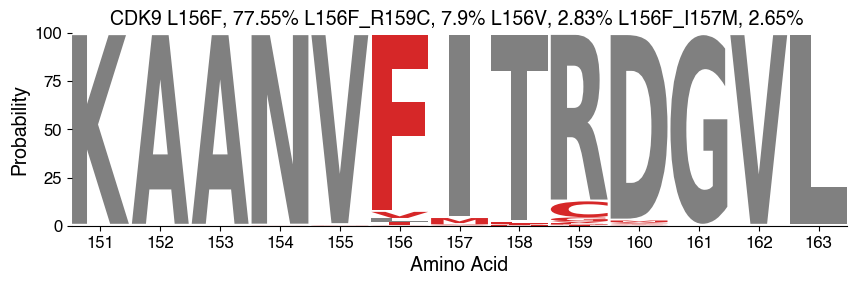

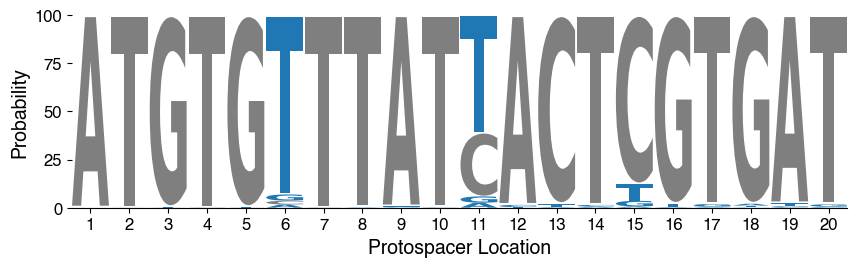

In [1294]:
gRNA_id = top_list[0]
subset = merge1[merge1['gRNA_id']==gRNA_id]
subset['%Reads'] = 100*subset['#Reads']/sum(subset['#Reads'])

wt_proto = subset['protospacer'].values[0]

dna_logo = pd.DataFrame(dict(zip(['Protospacer Location', 'A', 'T', 'C', 'G'], [list(range(1,21)), np.zeros(20), np.zeros(20), np.zeros(20), np.zeros(20)])))

for i, val in subset.iterrows():
    e = val['Edit']
    perc_reads = val['%Reads']
    if len(e)==20:
        for k, val2 in enumerate(e):
            location = k+1
            dna_logo.loc[(dna_logo['Protospacer Location']==location), val2]+=perc_reads

#merge1 = pd.merge(targ_pool1_cluster, all_combined, on='gRNA_id')
logo_df, min_cod, max_cod, d, d2, d3, d4, sequence = logo_df_maker(merge1, gRNA_id, context_size=3)

dna_and_protein_logo(logo_df, wt_proto, dna_logo, merge1)

In [1077]:
subset

,gRNA_id,Gene,protospacer,Protospacer,chrom,exon,proto_start,proto_end,PAM,PAM_start,...,RE_sites,gRNA_id_OLD,Edit,HGVSp,Num_edits,DNA Change,Canonical_edit,Canonical_window,#Reads,%Reads
1168222,gRNA_CDK19_targ_6538,CDK19,TCAAGAATCTGGTAAAGTAA,GCAAGAATCTGGTAAAGTAA,6.0,4,110667480.0,110667499.0,GG,110667500.0,...,2,gRNA_294,TCAAGAATTTGGTAAAGTAA,WT,1,"+9C>T,",True,False,11105,29.862586
1168223,gRNA_CDK19_targ_6538,CDK19,TCAAGAATCTGGTAAAGTAA,GCAAGAATCTGGTAAAGTAA,6.0,4,110667480.0,110667499.0,GG,110667500.0,...,2,gRNA_294,TCAAGAATGTGGTAAAGTAA,Q134H,1,"+9C>G,",False,False,10814,29.080055
1168224,gRNA_CDK19_targ_6538,CDK19,TCAAGAATCTGGTAAAGTAA,GCAAGAATCTGGTAAAGTAA,6.0,4,110667480.0,110667499.0,GG,110667500.0,...,2,gRNA_294,TCAAGAATCTGGTAAAGTAA,WT,0,No edit,True,True,9701,26.087073
1168225,gRNA_CDK19_targ_6538,CDK19,TCAAGAATCTGGTAAAGTAA,GCAAGAATCTGGTAAAGTAA,6.0,4,110667480.0,110667499.0,GG,110667500.0,...,2,gRNA_294,TTAAGAATCTGGTAAAGTAA,D137N,1,"+2C>T,",True,False,1711,4.601070
1168226,gRNA_CDK19_targ_6538,CDK19,TCAAGAATCTGGTAAAGTAA,GCAAGAATCTGGTAAAGTAA,6.0,4,110667480.0,110667499.0,GG,110667500.0,...,2,gRNA_294,TGAAGAATCTGGTAAAGTAA,D137H,1,"+2C>G,",False,False,1062,2.855837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168436,gRNA_CDK19_targ_6538,CDK19,TCAAGAATCTGGTAAAGTAA,GCAAGAATCTGGTAAAGTAA,6.0,4,110667480.0,110667499.0,GG,110667500.0,...,2,gRNA_294,TTAAGAATTTGGTAAAGTTA,L131*_D137N,3,"+2C>T,+9C>T,+19A>T,",False,False,1,0.002689
1168437,gRNA_CDK19_targ_6538,CDK19,TCAAGAATCTGGTAAAGTAA,GCAAGAATCTGGTAAAGTAA,6.0,4,110667480.0,110667499.0,GG,110667500.0,...,2,gRNA_294,TTAAGAATTTGGTAACGTAA,L132R_D137N,3,"+2C>T,+9C>T,+16A>C,",False,False,1,0.002689
1168438,gRNA_CDK19_targ_6538,CDK19,TCAAGAATCTGGTAAAGTAA,GCAAGAATCTGGTAAAGTAA,6.0,4,110667480.0,110667499.0,GG,110667500.0,...,2,gRNA_294,TTAGAATCTGGTAAAGTAAG,L132T_Y133L_Q134P_I135D_L136S_D137N,13,"+2C>T,+4A>G,+5G>A,+7A>T,+8T>C,+9C>T,+10T>G,+12...",False,False,1,0.002689
1168439,gRNA_CDK19_targ_6538,CDK19,TCAAGAATCTGGTAAAGTAA,GCAAGAATCTGGTAAAGTAA,6.0,4,110667480.0,110667499.0,GG,110667500.0,...,2,gRNA_294,TTAGGAATTTGGTAAAGTAA,L136P_D137N,3,"+2C>T,+4A>G,+9C>T,",False,False,1,0.002689


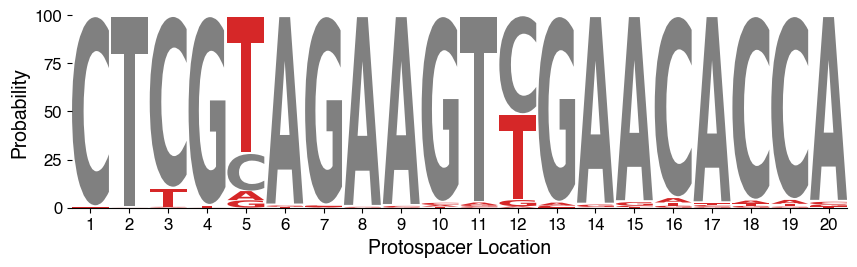

In [935]:
logo_df = dna_logo.set_index('Protospacer Location')

import logomaker

ss_logo = logomaker.Logo(logo_df, vpad = .02) #color_scheme='chemistry', vpad=.02)

# style using Logo methods
#ss_logo.highlight_position(p=min_cod, color='gold', alpha=.5)
#ss_logo.highlight_position(p=max_cod, color='gold', alpha=.5)

ss_logo.style_spines(spines=['left', 'right', 'top'], visible=False)

ss_logo.style_xticks(anchor=0, spacing=1, rotation=0, fontsize=12)
ss_logo.ax.set_yticks([0,25, 50, 75,100])
ss_logo.ax.set_yticklabels([0,25, 50, 75,100], fontsize=12);
ss_logo.ax.set_xlabel('Protospacer Location', fontsize=14)
ss_logo.ax.set_ylabel('Probability', fontsize=14)

ss_logo.ax.get_xticks()


for i, val in enumerate(wt_proto):
    loc = i+1
    bases = ['A','T','C','G']
    bases.remove(val)
    ss_logo.style_single_glyph(c=val, p=loc, color='grey')
    for k in bases:
        ss_logo.style_single_glyph(c=k, p=loc, color='tab:red')